# **Project Overview**

This is an in-depth notebook that explores an Austin Housing Datset scraped from Zillow.  The notebook includes a thorough EDA and cleaning section, Feature engineering, machine learning model explorations and evaluations, as well as model visualizations. 

# **Preprocessing** 

**EDA and Cleaning**

-Scaling  target variable for Time Series

-Detect Duplicates

-Detect Outliers

-Find Missing Data

-Convert Categorical Data to Numerical

-Feature Engineering

-Explore Relationships
-Explore Target/Dependent Variable

**Correlations and Multicollinearity**

-Correlation With Target variable

-Variance Inlation Factor

-Feature Selection

**Create Training and Test Sets**

**Visualizations**

**Linear Regressions**

**Random Forest Regression**

**Classification**

**Model Visualizations/Explorations**



In [1]:
#import modules

#data processing tools

import pandas as pd
import numpy as np
import geopy.distance

#visualization modules
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


#Machine learning tools
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import sklearn.metrics as mt
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression



In [2]:
#Read Data

data=pd.read_csv('austinHousingData.csv')

In [3]:
#info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15171 entries, 0 to 15170
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zpid                        15171 non-null  int64  
 1   city                        15171 non-null  object 
 2   streetAddress               15171 non-null  object 
 3   zipcode                     15171 non-null  int64  
 4   description                 15171 non-null  object 
 5   latitude                    15171 non-null  float64
 6   longitude                   15171 non-null  float64
 7   propertyTaxRate             15171 non-null  float64
 8   garageSpaces                15171 non-null  int64  
 9   hasAssociation              15171 non-null  bool   
 10  hasCooling                  15171 non-null  bool   
 11  hasGarage                   15171 non-null  bool   
 12  hasHeating                  15171 non-null  bool   
 13  hasSpa                      151

In [4]:
#Check for duplicated data


#Check for duplicated data
dupes=data.duplicated()

print("# of duplicated rows = %d" % (dupes.sum()))

# of duplicated rows = 0


In [5]:
#Check for nulls

print("Number of Instances = %d" % (data.isnull().sum().sum()))
print("Number of Attributes = %d" % (len(data.isnull().sum())))
print("-------------------------")

data.isnull().sum()

Number of Instances = 0
Number of Attributes = 47
-------------------------


zpid                          0
city                          0
streetAddress                 0
zipcode                       0
description                   0
latitude                      0
longitude                     0
propertyTaxRate               0
garageSpaces                  0
hasAssociation                0
hasCooling                    0
hasGarage                     0
hasHeating                    0
hasSpa                        0
hasView                       0
homeType                      0
parkingSpaces                 0
yearBuilt                     0
latestPrice                   0
numPriceChanges               0
latest_saledate               0
latest_salemonth              0
latest_saleyear               0
latestPriceSource             0
numOfPhotos                   0
numOfAccessibilityFeatures    0
numOfAppliances               0
numOfParkingFeatures          0
numOfPatioAndPorchFeatures    0
numOfSecurityFeatures         0
numOfWaterfrontFeatures       0
numOfWin

# EDA & Preprocessing


**Scale Time Series**

In [6]:
data.rename(columns={'latestPrice':'price'}, inplace=True)

In [7]:
#Drill into individual dates
print(data['latest_saledate'].min())
print(data['latest_saledate'].max())

2018-01-22
2021-01-30


**Standardizing Continuous Time Series with appreciation**

We need to standardize our data.  We went to the Texas A&M Real Estate Center for house price appreciation information

https://www.recenter.tamu.edu/data/home-price-index/#!/MSA/Austin-Round_Rock

The index for Q1 2018 was 208.00
Q1 2019 : It was at 216.52, +4.09%
Q1 2020 : Index @ 229.7 , +6.09%
Q1 2021 : 283.45 , +23.4%

In [8]:
#Adjusting the data using house price index info

jan2018_to_2019 = .0409/12
jan2019_to_2020 = .0609/12
jan2020_to_2021 = .234/12

# create reverse time series number for month
for i in range(1,13):
    data['time_series'] = data['latest_salemonth'].apply(lambda x: abs(x-13))


In [9]:
# adjust 2018 to 2019
data.loc[data['latest_saleyear']==2018, 'adj_price'] = data.loc[data['latest_saleyear']==2018].apply(lambda x: int( (x['price'])*(1+(jan2018_to_2019*x['time_series']))*(1+(jan2019_to_2020*x['time_series']))*(1+(jan2020_to_2021*x['time_series'])) ) , axis=1 )

# adjust 2019 to 2020                                                            
data.loc[data['latest_saleyear']==2019, 'adj_price'] = data.loc[data['latest_saleyear']==2019].apply(lambda x: int( (x['price'])*(1+(jan2019_to_2020*x['time_series']))*(1+(jan2020_to_2021*x['time_series'])) ) , axis=1)
                                                                                  
# adjust 2020 to 2021
data.loc[data['latest_saleyear']==2020, 'adj_price'] = data.loc[data['latest_saleyear']==2020].apply(lambda x: int( (x['price'])*(1+(jan2020_to_2021*x['time_series'])) ), axis=1)

#copy 2021 to self
data.loc[data['latest_saleyear']==2021, 'adj_price'] = data.loc[data['latest_saleyear']==2021].apply(lambda x: int(x['price']), axis=1)

# rename original price column and make adj_price our price column
data.rename(columns={'price' : 'orig_price', 'adj_price' : 'price'}, inplace=True)

# put price at the front of the data frame
data.set_index('price', inplace=True)
data.reset_index(inplace=True)

In [10]:
#look at numerical variables only

newdf = data.select_dtypes(exclude=('object','bool'))


array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'zpid'}>,
        <AxesSubplot:title={'center':'zipcode'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'propertyTaxRate'}>],
       [<AxesSubplot:title={'center':'garageSpaces'}>,
        <AxesSubplot:title={'center':'parkingSpaces'}>,
        <AxesSubplot:title={'center':'yearBuilt'}>,
        <AxesSubplot:title={'center':'orig_price'}>,
        <AxesSubplot:title={'center':'numPriceChanges'}>,
        <AxesSubplot:title={'center':'latest_salemonth'}>],
       [<AxesSubplot:title={'center':'latest_saleyear'}>,
        <AxesSubplot:title={'center':'numOfPhotos'}>,
        <AxesSubplot:title={'center':'numOfAccessibilityFeatures'}>,
        <AxesSubplot:title={'center':'numOfAppliances'}>,
        <AxesSubplot:title={'center':'numOfParkingFeatures'}>,
        <AxesSubplot:title={'center':'numOfPatioAndPorchF

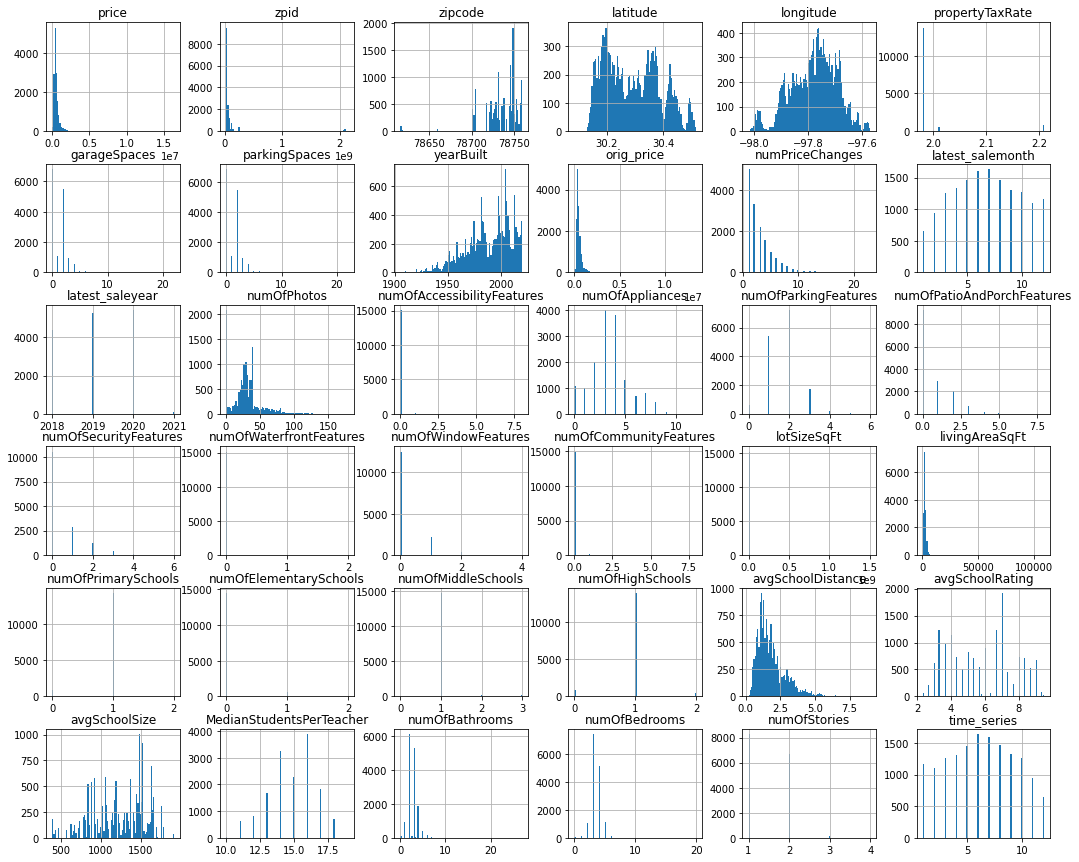

In [11]:
#There are many features, look at a matrix first

newdf.hist(figsize=(18,15),bins=100)


<AxesSubplot:>

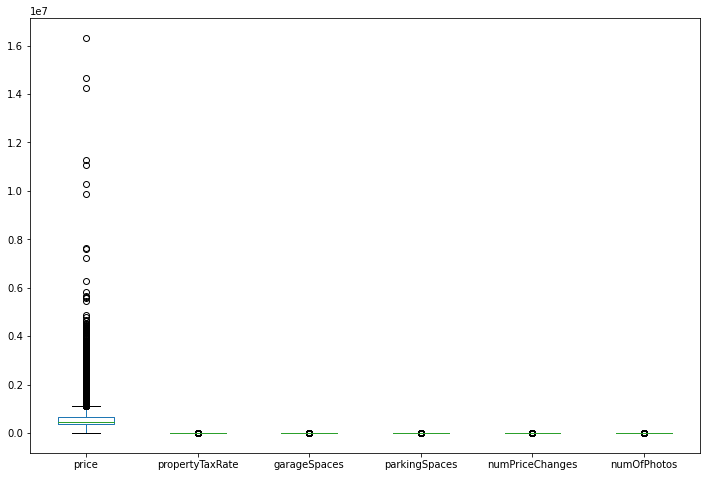

In [12]:
#Box plots for all features true numerical features - excluding zipcode, latitude/longitude splitting it up because of size

newdf[['price', 'propertyTaxRate', 'garageSpaces','parkingSpaces','numPriceChanges','numOfPhotos']].plot.box(figsize = (12, 8))

In [13]:
newdf.columns

Index(['price', 'zpid', 'zipcode', 'latitude', 'longitude', 'propertyTaxRate',
       'garageSpaces', 'parkingSpaces', 'yearBuilt', 'orig_price',
       'numPriceChanges', 'latest_salemonth', 'latest_saleyear', 'numOfPhotos',
       'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools',
       'numOfHighSchools', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms',
       'numOfBedrooms', 'numOfStories', 'time_series'],
      dtype='object')

**Create A Years old columns**


In [14]:
#create a columns for how old the dwelling is based on yearbuilt
#data was scraped in January 2021, so for the sake of consistency, we are treating the age of the house as if it were still 2021
reference_year = 2021

data['YearsOld']=reference_year - data['yearBuilt']


#modify the numerical data as well

newdf['YearsOld']=reference_year - newdf['yearBuilt']
data['YearsOld'].describe()

/Users/adamaldeen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


count    15171.000000
mean        32.445257
std         21.579458
min          1.000000
25%         15.000000
50%         28.000000
75%         47.000000
max        116.000000
Name: YearsOld, dtype: float64

<AxesSubplot:>

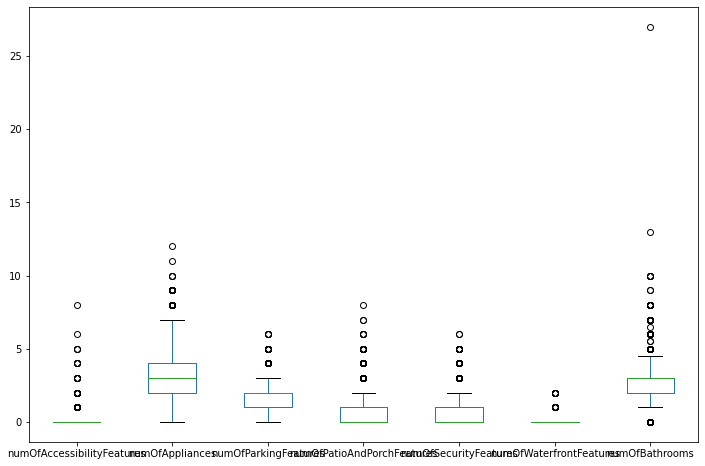

In [15]:
#Continue looking for outliers
newdf[['numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures','numOfPatioAndPorchFeatures','numOfSecurityFeatures','numOfWaterfrontFeatures','numOfBathrooms']].plot.box(figsize = (12, 8))

<AxesSubplot:>

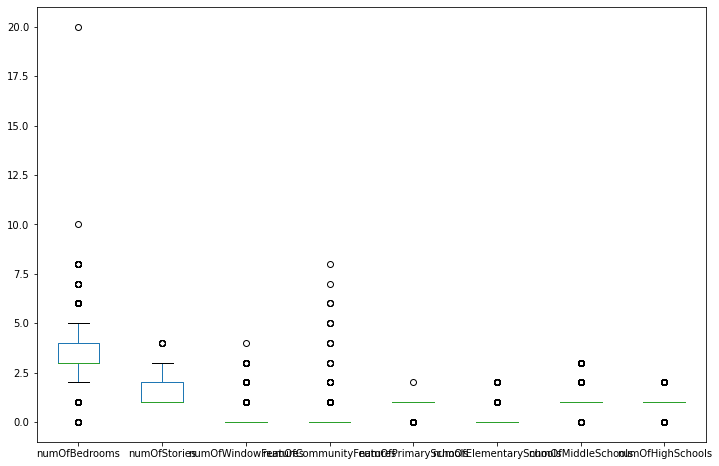

In [16]:
#Continue looking for outliers
newdf[['numOfBedrooms','numOfStories','numOfWindowFeatures', 'numOfCommunityFeatures', 'numOfPrimarySchools','numOfElementarySchools','numOfMiddleSchools','numOfHighSchools']].plot.box(figsize = (12, 8))

<AxesSubplot:>

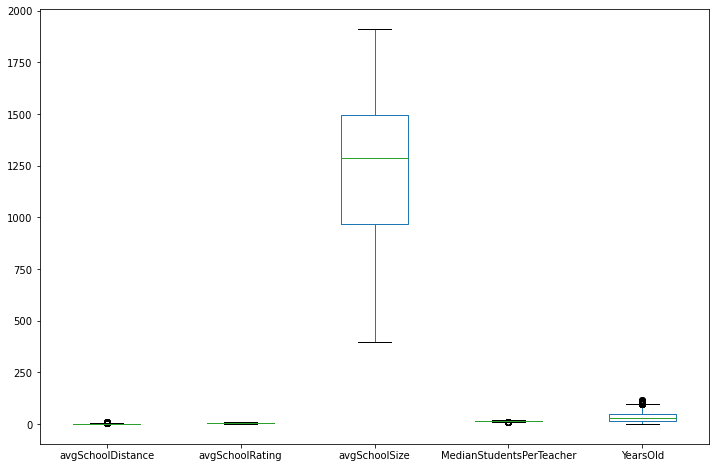

In [17]:
#Continue looking for outliers
newdf[[ 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'YearsOld']].plot.box(figsize = (12, 8))

<AxesSubplot:>

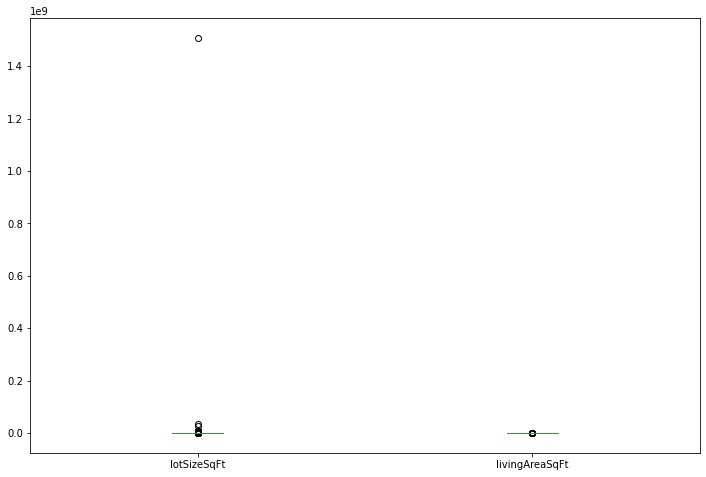

In [18]:
newdf[['lotSizeSqFt', 'livingAreaSqFt']].plot.box(figsize = (12, 8))

The moral of the stroy here is that many, if not all feature are displaying a a number of outliers in the data. 

In [19]:
#Check on different types of hometypes
data['homeType'].value_counts(normalize=True)


Single Family            0.938699
Condo                    0.030980
Townhouse                0.011469
Multiple Occupancy       0.006328
Vacant Land              0.005471
Residential              0.002439
Apartment                0.002439
Mobile / Manufactured    0.001121
MultiFamily              0.000659
Other                    0.000395
Name: homeType, dtype: float64

Single family homes account for ~94% of the listings in the dataset.  It is possible some of our outliers are caused by multifamily and other listing types

We will concentrate on SIngle Family homes, Condos, and Townhouses


In [20]:
#Dropping other hometypes

df = data.loc[((data['homeType'] == 'Single Family') | (data['homeType'] == 'Condo')) | (data['homeType'] == 'Townhouse')]
#Data check
df.shape

(14885, 50)

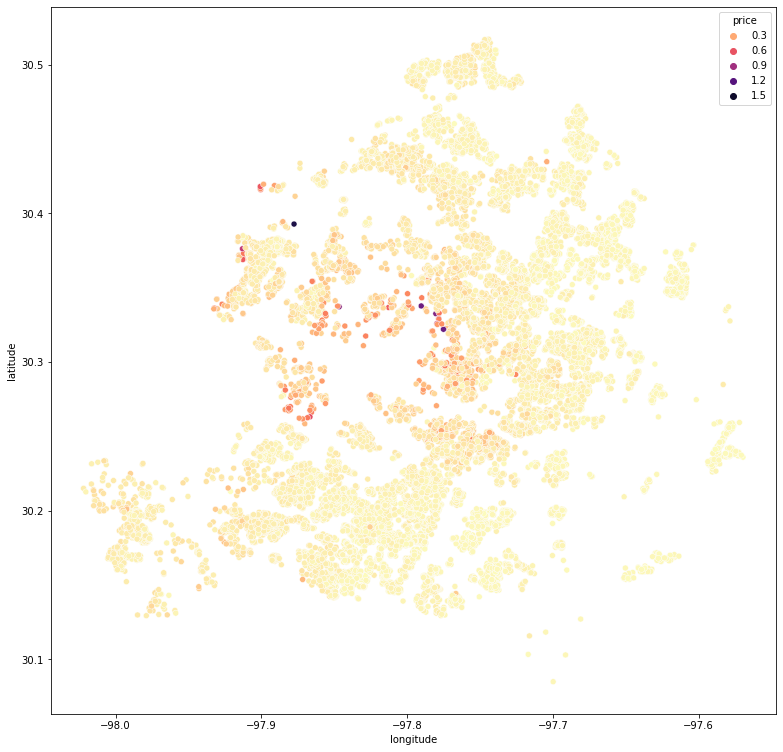

In [21]:
# plotting latitude and longitude as a visual scatter plot to look for location-based outliers

plt.figure(figsize=(13,13))

sns.scatterplot(data=df, x="longitude", y="latitude", hue="price", palette="magma_r");

This visualization suggests that location is very important to the price of a home

In [22]:
df['livingAreaSqFt'].describe()

count     14885.000000
mean       2205.469735
std        1367.932682
min         300.000000
25%        1485.000000
50%        1976.000000
75%        2687.000000
max      109292.000000
Name: livingAreaSqFt, dtype: float64

**Removing Outliers - IQR and Z Score**

It is clear that there are a number of potentially errant data in this set.  We will handle this by first calculating z scores for the data and dropping the most errant data from all of the columns. Define as z score >=3

In [23]:
# Z score method
from scipy import stats
#create list of numerical columns
cols=list(df.select_dtypes(exclude=('bool','object')).columns)



for col in cols:
    col_zscore = col + '_zscore'
    df[col_zscore] = (np.abs(stats.zscore(df[col])))
#Datacheck now    
df.shape


/Users/adamaldeen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


(14885, 87)

**begin removing outliers based on Z score**

In [24]:
#we will drop all values where the squarefootage is >=3

df= df.loc[df['livingAreaSqFt_zscore']<3]

In [25]:
#remove lotsize outliers
df= df.loc[df['lotSizeSqFt_zscore']<3]

#Explore #bathrooms
df['numOfBathrooms'].value_counts(normalize=True)

2.00     0.406890
3.00     0.355015
4.00     0.124215
1.00     0.062074
5.00     0.026613
6.00     0.008713
2.50     0.008376
3.50     0.002972
7.00     0.001891
0.00     0.001351
1.50     0.000878
4.50     0.000270
1.75     0.000203
8.00     0.000135
5.50     0.000135
2.75     0.000135
1.70     0.000068
27.00    0.000068
Name: numOfBathrooms, dtype: float64

<AxesSubplot:>

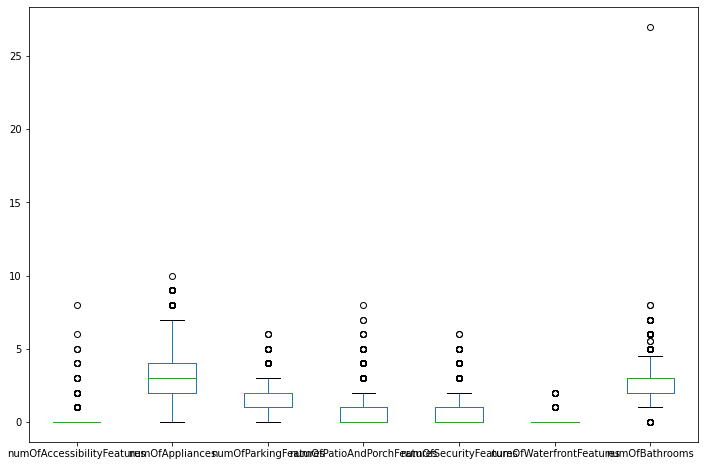

In [26]:
#Visualize some outliers again
#Continue looking for outliers
df[['numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures','numOfPatioAndPorchFeatures','numOfSecurityFeatures','numOfWaterfrontFeatures','numOfBathrooms']].plot.box(figsize = (12, 8))

Strange to see 0 for bathrooms and 27
Let's look into that


In [27]:
print(df['numOfBathrooms'].max())
print(df['numOfBathrooms'].min())

27.0
0.0


In [28]:
df.loc[df['numOfBathrooms']==27]

,price,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,...,numOfHighSchools_zscore,avgSchoolDistance_zscore,avgSchoolRating_zscore,avgSchoolSize_zscore,MedianStudentsPerTeacher_zscore,numOfBathrooms_zscore,numOfBedrooms_zscore,numOfStories_zscore,time_series_zscore,YearsOld_zscore
2838,788582.0,111972888,austin,4212 Far West Blvd,78731,Well-maintained home in highly desirable North...,30.361406,-97.769707,1.98,2,...,0.076482,0.849712,0.649583,0.745518,0.649194,23.693934,0.687838,0.89587,1.044474,1.010146


In [29]:
df['numOfBathrooms'].describe()

count    14805.000000
mean         2.674701
std          0.974638
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max         27.000000
Name: numOfBathrooms, dtype: float64

In [30]:
#Remove 0 bathroom entries
df=df.loc[df['numOfBathrooms']!=0]

In [31]:
#Sanity check that there are no more 0's for bathrooms
df['numOfBathrooms'].describe()

count    14785.000000
mean         2.678319
std          0.970316
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max         27.000000
Name: numOfBathrooms, dtype: float64

<AxesSubplot:>

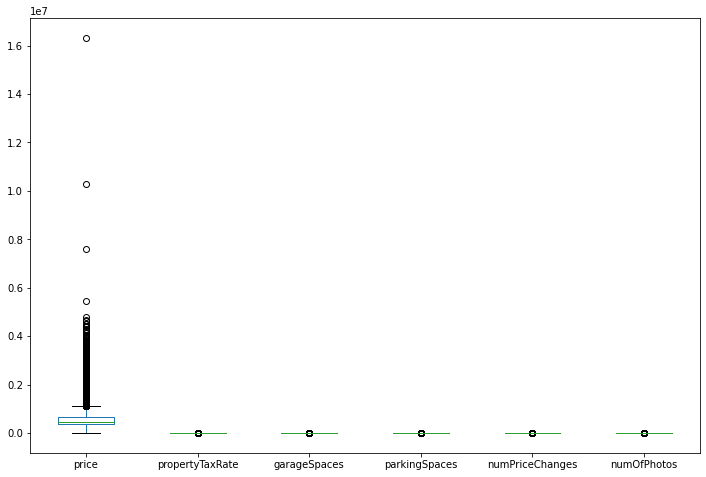

In [32]:
#Box plots for all features true numerical features - excluding zipcode, latitude/longitude splitting it up because of size

df[['price', 'propertyTaxRate', 'garageSpaces','parkingSpaces','numPriceChanges','numOfPhotos']].plot.box(figsize = (12, 8))

<AxesSubplot:>

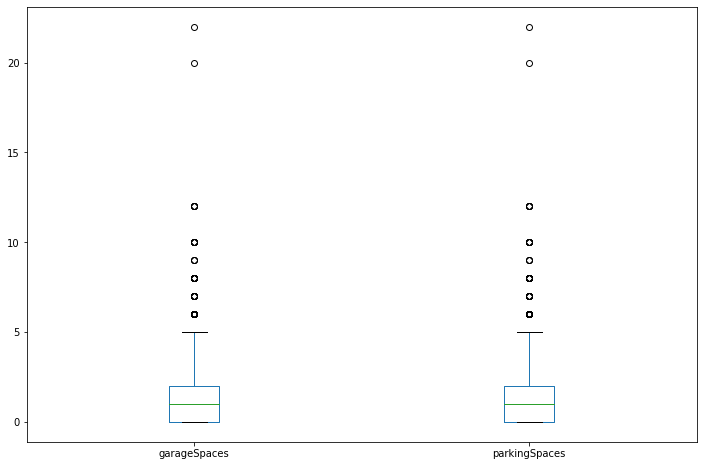

In [33]:
##Look at garage spaces in mroe detail
df[['garageSpaces','parkingSpaces']].plot.box(figsize = (12, 8))


In [34]:
df.loc[df['garageSpaces']>15]

,price,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,...,numOfHighSchools_zscore,avgSchoolDistance_zscore,avgSchoolRating_zscore,avgSchoolSize_zscore,MedianStudentsPerTeacher_zscore,numOfBathrooms_zscore,numOfBedrooms_zscore,numOfStories_zscore,time_series_zscore,YearsOld_zscore
4533,1071085.0,28587235,austin,13100 Rooster Springs Rd,78737,Enjoy country living with the convenience of t...,30.204746,-97.991356,2.01,20,...,0.076482,4.617791,0.470365,0.332361,0.649194,2.245633,0.687838,0.89587,1.186497,1.361723
6885,414560.0,145656156,austin,705 Mc Queen St #34,78745,Beautiful 2-story home located in highly sough...,30.189331,-97.792809,1.98,22,...,0.076482,0.912198,1.321813,0.964963,1.072084,0.295788,0.687838,0.89587,1.363184,1.268708


In [35]:
df.shape

(14785, 87)

**So many of these features have what seems to be bogus entries.**

**We will use our z score method from above on all num_attributes**


In [36]:
df.columns

Index(['price', 'zpid', 'city', 'streetAddress', 'zipcode', 'description',
       'latitude', 'longitude', 'propertyTaxRate', 'garageSpaces',
       'hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa',
       'hasView', 'homeType', 'parkingSpaces', 'yearBuilt', 'orig_price',
       'numPriceChanges', 'latest_saledate', 'latest_salemonth',
       'latest_saleyear', 'latestPriceSource', 'numOfPhotos',
       'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools',
       'numOfHighSchools', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms',
       'numOfBedrooms', 'numOfStories', 'homeImage', 'time_series', 'YearsOld',
       'price_zscore'

In [37]:
#Begin Dropping rows with extreme values,  some are very far outliers and won't lead to good modelliung of the price


df= df.loc[df['garageSpaces_zscore']<3]
df= df.loc[df['parkingSpaces_zscore']<3]
df= df.loc[df['numOfBedrooms_zscore']<3]
df= df.loc[df['numOfStories_zscore']<3]
df= df.loc[df['numOfAccessibilityFeatures_zscore']<3]
df= df.loc[df['numOfAppliances_zscore']<3]
df= df.loc[df['numOfParkingFeatures_zscore']<3]
df=df.loc[df['numOfBathrooms_zscore']<3]
df= df.loc[df['numOfPatioAndPorchFeatures_zscore']<3]
df= df.loc[df['numOfSecurityFeatures_zscore']<3]
df= df.loc[df['numOfWaterfrontFeatures_zscore']<3]

df= df.loc[df['numOfWindowFeatures_zscore']<3]
df= df.loc[df['numOfCommunityFeatures_zscore']<3]
df= df.loc[df['price_zscore']<3]

In [38]:
# A lot of our variables are not normally shaped, so we can't reliably remove all outliers via standard deviation.
# We will use IQR to further filter our outliers with the following function

def iqr_outliers(column):
    """return the lower range and upper range for the data based on IQR*1.5"""
    Q1,Q3 = np.percentile(column , [25,75])
    iqr = Q3 - Q1
    lower_range = Q1 - (1.5 * iqr)
    upper_range = Q3 + (1.5 * iqr)
    return lower_range,upper_range  

In [39]:
# determing our IQR for price, lot size, sq footage and longitude
lotlower,lotupper = iqr_outliers(df.lotSizeSqFt)
sqftlower, sqftupper = iqr_outliers(df.livingAreaSqFt)
pricelower, priceupper = iqr_outliers(df.price)
# dropping the things outside of our lower and upper range
df.drop(df[ (df.lotSizeSqFt > lotupper) | (df.lotSizeSqFt < lotlower) ].index , inplace=True)
df.drop(df[ (df.livingAreaSqFt > sqftupper) | (df.livingAreaSqFt < sqftlower) ].index , inplace=True)
df.drop(df[ (df.price > priceupper) | (df.price < pricelower) ].index , inplace=True)

<AxesSubplot:>

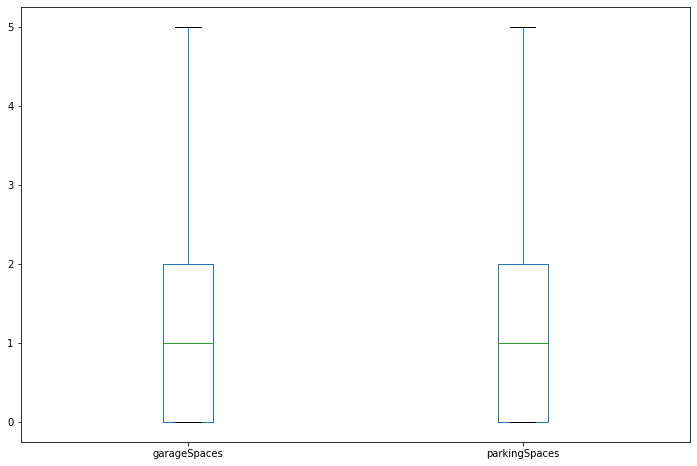

In [40]:
#Sanity check\
##Look at garage spaces in mroe detail for outliers
df[['garageSpaces','parkingSpaces']].plot.box(figsize = (12, 8))

<AxesSubplot:>

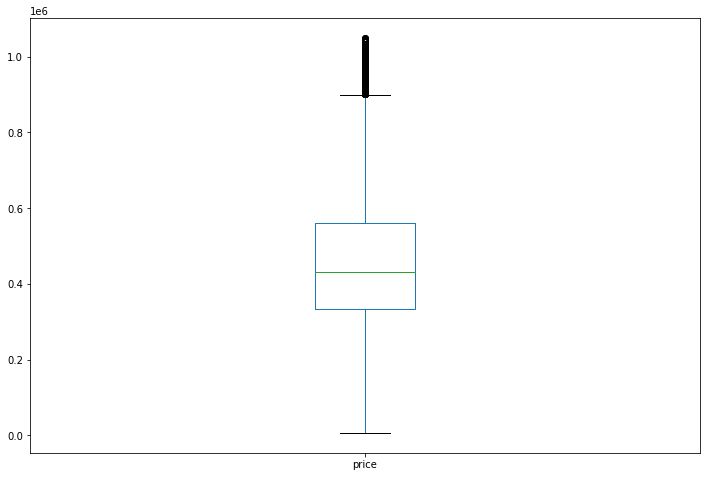

In [41]:
#Drill into price now

df['price'].plot.box(figsize = (12, 8))

#price still seem to be showing extremes

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'zpid'}>,
        <AxesSubplot:title={'center':'zipcode'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'propertyTaxRate'}>,
        <AxesSubplot:title={'center':'garageSpaces'}>,
        <AxesSubplot:title={'center':'parkingSpaces'}>,
        <AxesSubplot:title={'center':'yearBuilt'}>],
       [<AxesSubplot:title={'center':'orig_price'}>,
        <AxesSubplot:title={'center':'numPriceChanges'}>,
        <AxesSubplot:title={'center':'latest_salemonth'}>,
        <AxesSubplot:title={'center':'latest_saleyear'}>,
        <AxesSubplot:title={'center':'numOfPhotos'}>,
        <AxesSubplot:title={'center':'numOfAccessibilityFeatures'}>,
        <AxesSubplot:title={'center':'numOfAppliances'}>,
        <AxesSubplot:title={'center':'numOfParkingFeatures'}>,
        <AxesSubplot:title={'center':'numOfPatioAndPorchFe

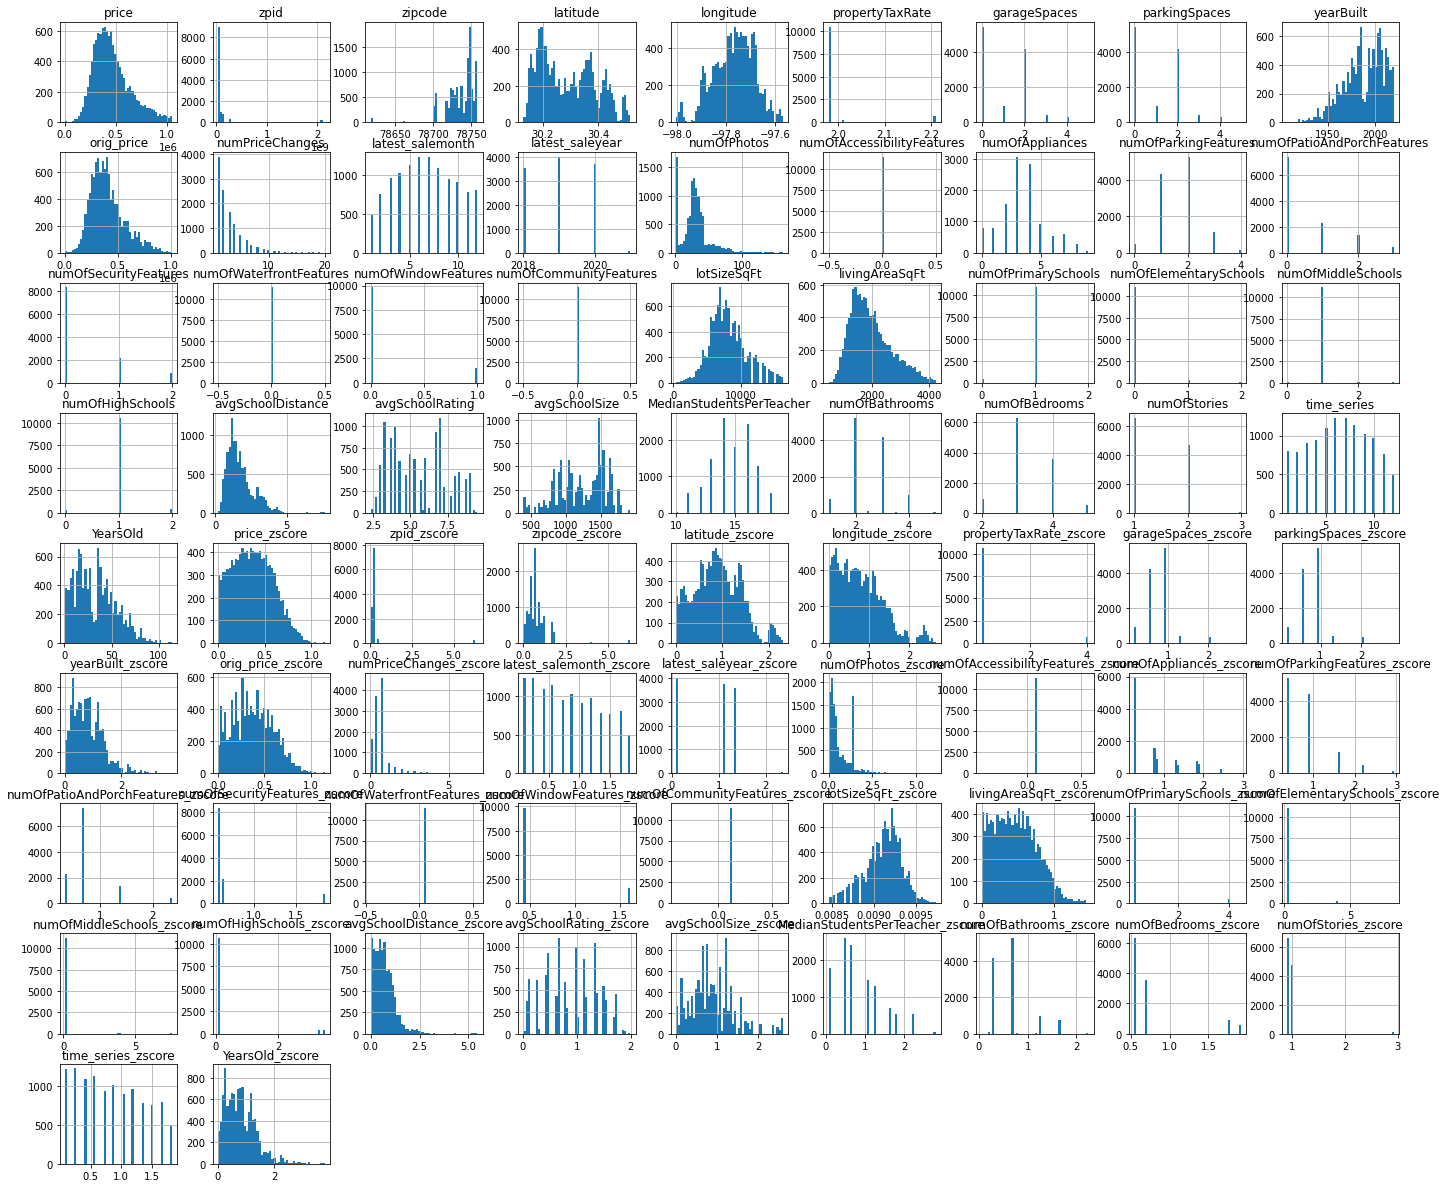

In [42]:
# check how our histograms are looking for our columns that seem to have outliers
df.hist(figsize=(24,21),bins=50)

In [43]:
#Check how many features are left
df.shape

(11367, 87)

<AxesSubplot:>

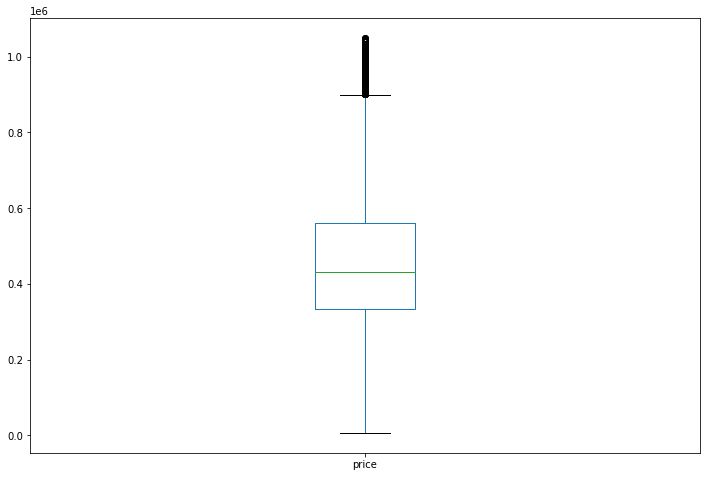

In [44]:
#Check box pot again
df['price'].plot.box(figsize = (12, 8))

In [45]:

#Also seeing some weird values on the low end deserving further investigation
#Further drill into target variable
df['price'].min()


6294.0

In [46]:
#check lower priced homes
df.sort_values(by='price',ascending=True).head(5)


,price,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,...,numOfHighSchools_zscore,avgSchoolDistance_zscore,avgSchoolRating_zscore,avgSchoolSize_zscore,MedianStudentsPerTeacher_zscore,numOfBathrooms_zscore,numOfBedrooms_zscore,numOfStories_zscore,time_series_zscore,YearsOld_zscore
844,6294.0,29361735,austin,3302 Blue Jay Ln,78732,"3302 Blue Jay Ln, Austin, TX 78732 is a single...",30.383715,-97.913513,1.98,4,...,0.076482,1.024860,1.366454,0.724022,1.222953,2.245633,1.919609,0.895870,0.407054,0.524593
9310,6752.0,29381466,austin,1907 Holly St,78702,Be the first to move in this luxurious home! C...,30.253046,-97.725830,1.98,2,...,0.076482,0.693497,0.963377,2.552609,2.219603,0.295788,0.687838,1.012951,0.407054,1.408230
9272,7792.0,29471989,austin,1604 Eva St,78704,Rare one-of-a-kind chic home in Bouldin! Priva...,30.247984,-97.751869,1.98,2,...,0.076482,1.130898,0.784159,0.995672,0.498325,0.295788,0.543932,1.012951,1.363184,1.940290
14335,7860.0,29338824,austin,3602 River Rd,78703,Beautiful mid century modern home with a conte...,30.306955,-97.774506,1.98,2,...,0.076482,0.506040,0.649583,0.177405,0.649194,1.270710,0.543932,0.895870,0.549076,1.614739
14580,8054.0,29339192,austin,2800 Westlake Dr,78746,"Fabulous, sunny and comfortable in peaceful We...",30.309500,-97.781631,1.98,2,...,3.342260,0.759296,1.724890,1.316702,0.075435,1.758172,0.687838,1.012951,1.681895,0.199042


In [47]:
#Drop house price <80,000  ..arbitrary threshold to filter out questionable entries

#df.drop(df[ (df.price < 100000)].index , inplace=True)
df=df.loc[df['price']>100000]

In [48]:
#check data shape again
df.shape

(11338, 87)

<AxesSubplot:>

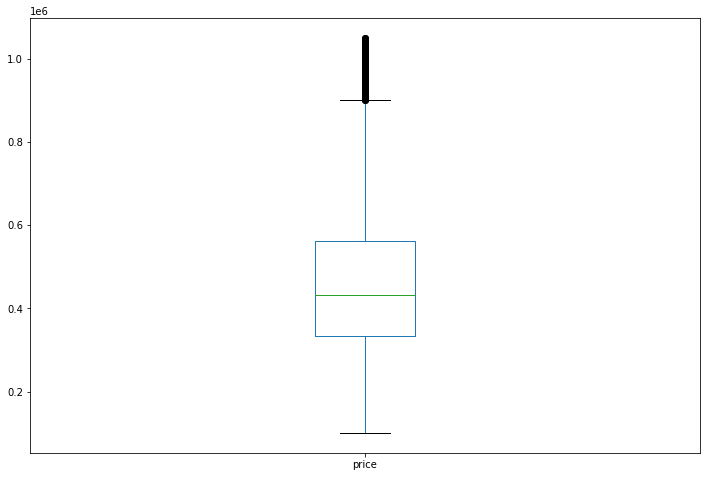

In [49]:
#Check box pot again
df['price'].plot.box(figsize = (12, 8))

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'zpid'}>,
        <AxesSubplot:title={'center':'zipcode'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'propertyTaxRate'}>,
        <AxesSubplot:title={'center':'garageSpaces'}>,
        <AxesSubplot:title={'center':'parkingSpaces'}>,
        <AxesSubplot:title={'center':'yearBuilt'}>],
       [<AxesSubplot:title={'center':'orig_price'}>,
        <AxesSubplot:title={'center':'numPriceChanges'}>,
        <AxesSubplot:title={'center':'latest_salemonth'}>,
        <AxesSubplot:title={'center':'latest_saleyear'}>,
        <AxesSubplot:title={'center':'numOfPhotos'}>,
        <AxesSubplot:title={'center':'numOfAccessibilityFeatures'}>,
        <AxesSubplot:title={'center':'numOfAppliances'}>,
        <AxesSubplot:title={'center':'numOfParkingFeatures'}>,
        <AxesSubplot:title={'center':'numOfPatioAndPorchFe

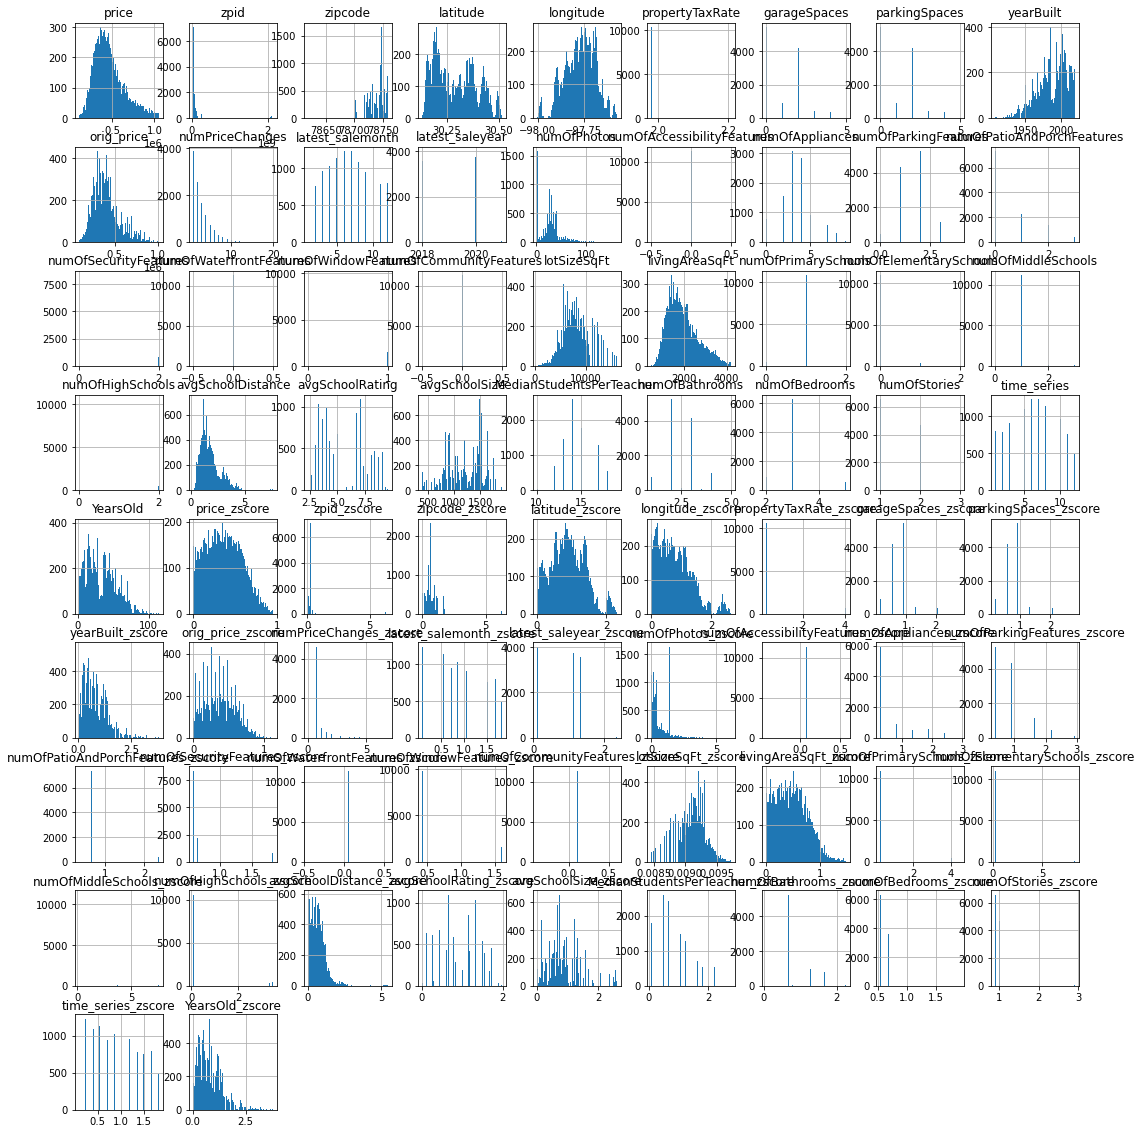

In [50]:
#and the histogram
df.hist(figsize=(18,20), bins=100)

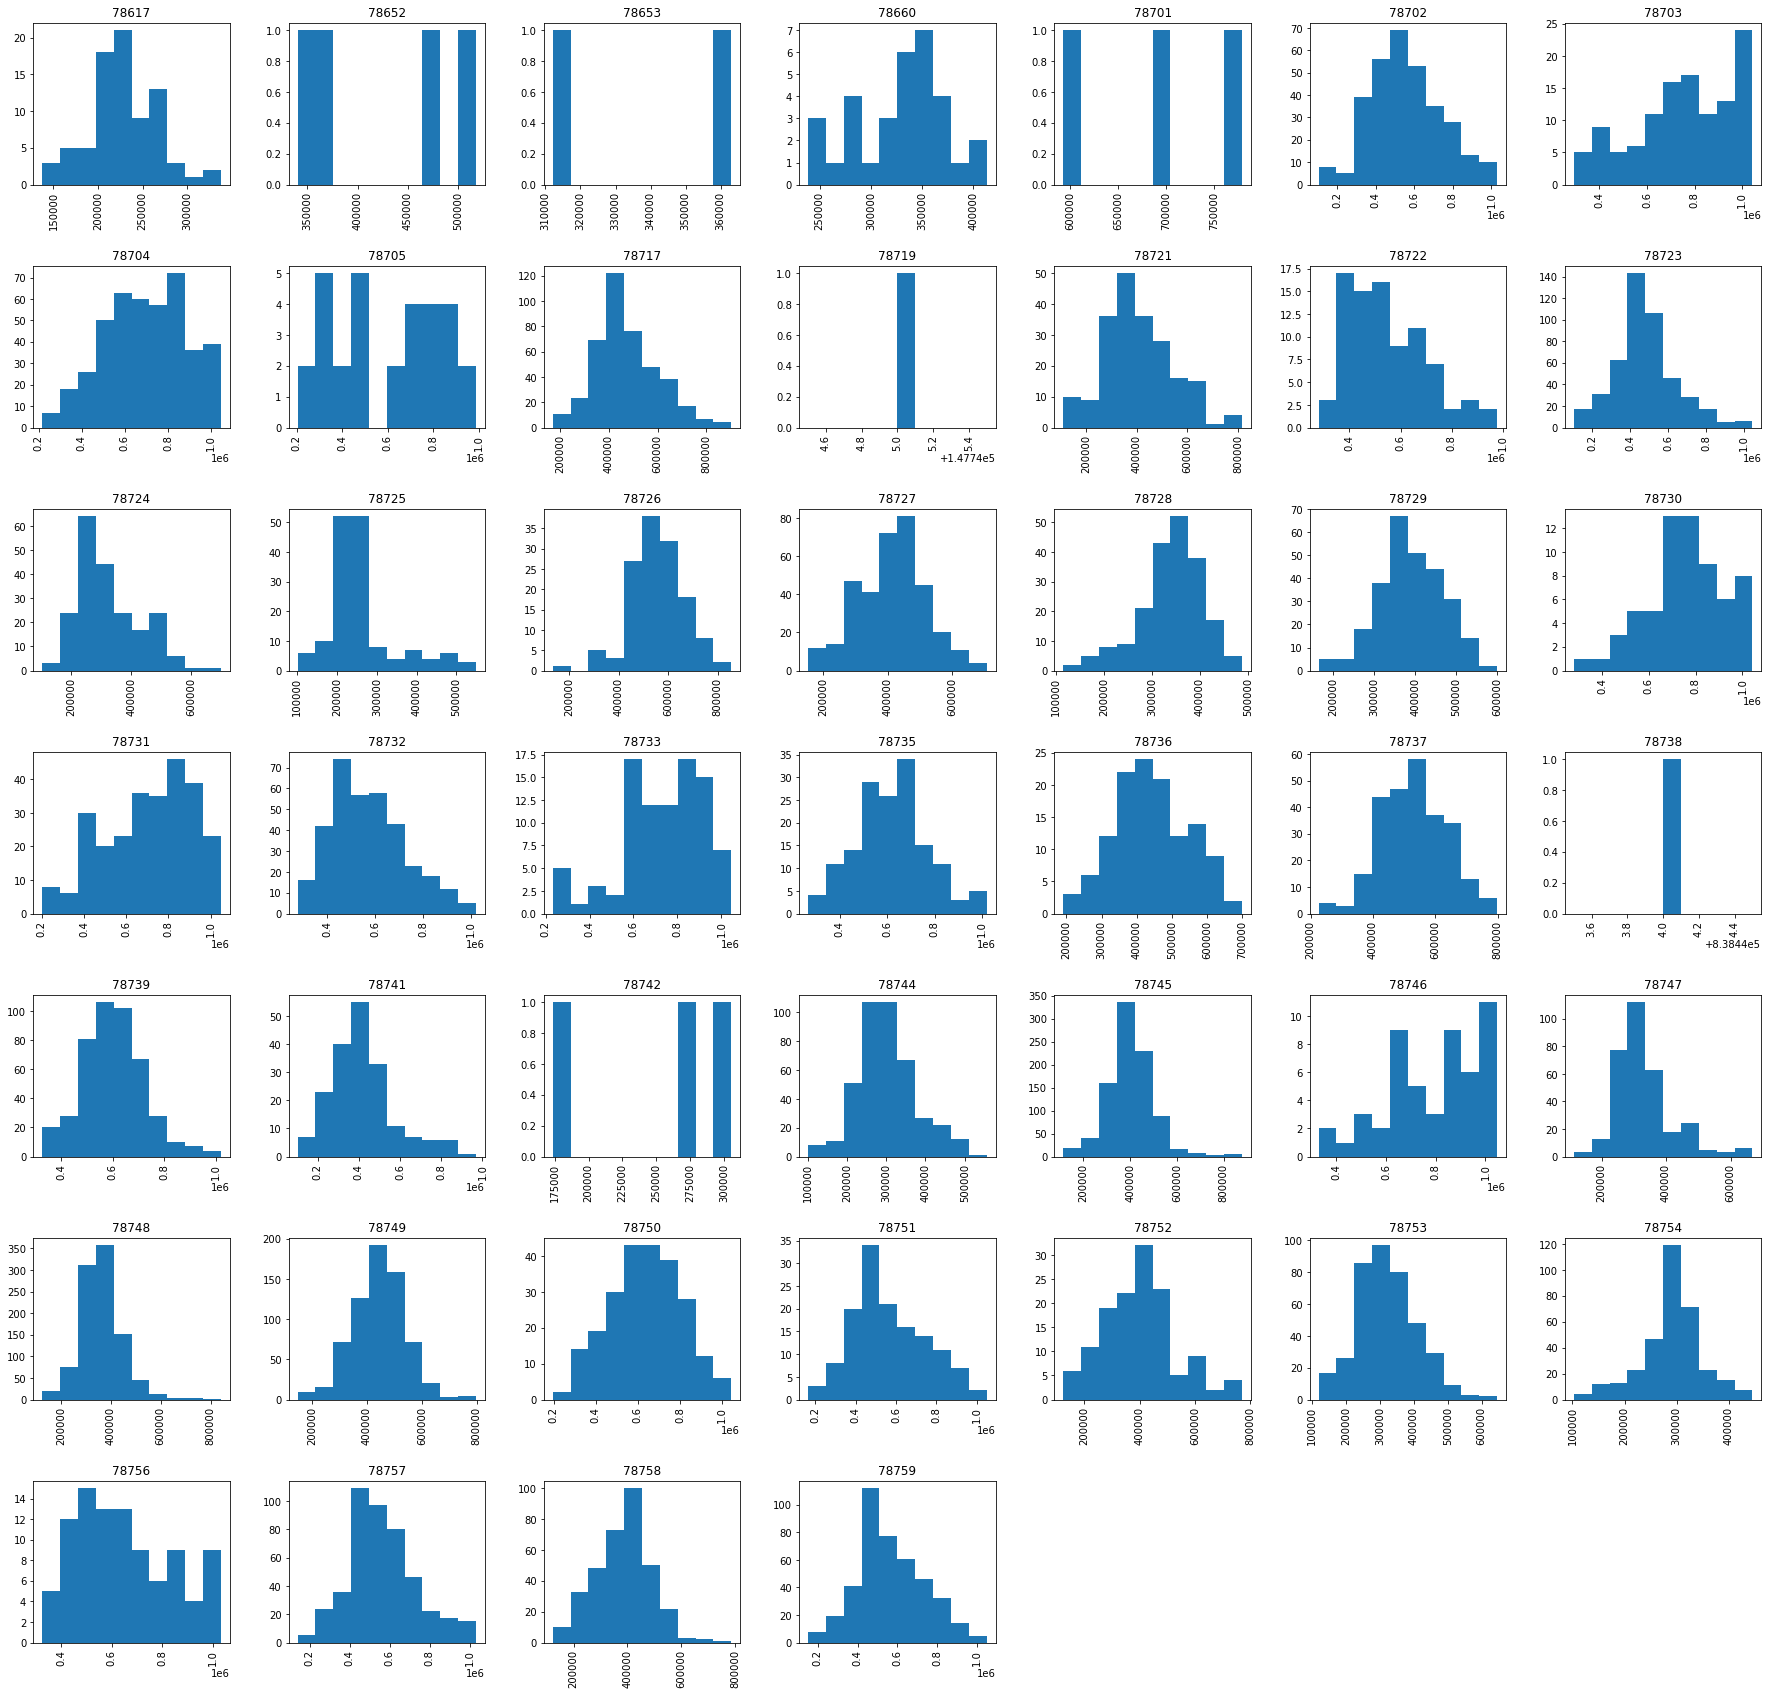

In [51]:
#Check influence of zipcode on price
#We can check our price per zip code histograms.

df['price'].hist(by=df['zipcode'], figsize=(30,30));  

In [52]:
#Which Zip COde has highest price
zip_group=df.groupby(['zipcode']).agg('price').mean()


In [53]:
zip_group.sort_values(ascending=False)

zipcode
78738    838444.000000
78746    792348.901961
78730    757571.437500
78703    755127.153846
78733    730843.010989
78731    705381.808271
78704    696870.355140
78701    689199.333333
78756    651216.526316
78750    637989.169492
78735    614875.223684
78739    603644.048565
78705    600900.433333
78732    571967.862069
78751    566349.801471
78759    564936.961446
78757    563626.374723
78702    557126.231013
78726    554620.589552
78722    549290.482353
78737    531829.229885
78723    481693.735931
78717    471753.881928
78749    445106.071217
78736    442765.664000
78652    425297.000000
78741    416297.820106
78727    413250.132565
78721    409330.614634
78745    401976.726269
78752    401833.812030
78729    389613.443636
78758    383078.964912
78748    360904.658859
78728    341811.615000
78653    337560.500000
78747    330474.836420
78660    328313.218750
78724    323301.254808
78753    322166.783375
78744    301898.641646
78754    290179.389222
78725    260426.671053
787

In [54]:
# Drop zip codes where we have only a couple of data points

df.drop( df.loc[(df['zipcode']==78653) | (df['zipcode']==78738) |(df['zipcode']==78701)| (df['zipcode']==78719)| (df['zipcode']==78652)| (df['zipcode']==78742)].index, axis=0, inplace=True)

#Check length of data again
df.shape

(11324, 87)

**Clearly Zipcode/location has a significant influence on price.  We will try to engineer a feture to incorporate this useful information**.

https://medium.com/@krexvelasco/transforming-categorical-information-into-usable-measures-in-a-machine-learning-model-e2910bbb3fc7

We decided to create a feature to measure the distance from the major economic centers of Austin using their respective latitudes and longitudes, in order to assess home price in the data set. Rather than re-inventing the wheel by creating a mathematical function, we decided to calculate distance using the geopy distance function for our first attempt


Austin Coordinates from here https://www.findlatitudeandlongitude.com/l/Downtown%2C+Austin%2C+Travis+County%2C+Texas%2C+78701%2C+USA/6072234/

For the formula, we needed to transform for the coordinates of each house. Given the latitude and longitude, we applied the zip function to create a new column of the coordinates as well as a reference point for the Austin City Center

In [55]:
df['lat_long']=tuple(zip(df.latitude,df.longitude))

#Coordinates from link above
austin=[30.2729,-97.7444]


In [56]:
austin_distance=[]
for i in df['lat_long']:
    austin_distance.append(geopy.distance.distance((austin),(i)).miles)
df['austin_distance']=pd.Series(austin_distance)    



In [57]:
df['austin_distance'].describe()

count    8453.000000
mean        7.746116
std         3.526598
min         0.614940
25%         4.957080
50%         7.867380
75%        10.197425
max        17.103208
Name: austin_distance, dtype: float64

In [58]:
#Check for nulls on newly calculated dataframe

print("Number of Instances = %d" % (df.isnull().sum().sum()))
print("Number of Attributes = %d" % (len(df.isnull().sum())))
print("-------------------------")

df.isnull().sum()

Number of Instances = 2871
Number of Attributes = 89
-------------------------


price                     0
zpid                      0
city                      0
streetAddress             0
zipcode                   0
                       ... 
numOfStories_zscore       0
time_series_zscore        0
YearsOld_zscore           0
lat_long                  0
austin_distance        2871
Length: 89, dtype: int64

In [59]:
#taking rows where not NA
df = df[df['austin_distance'].notna()]

#check after removing
df.shape


(8453, 89)

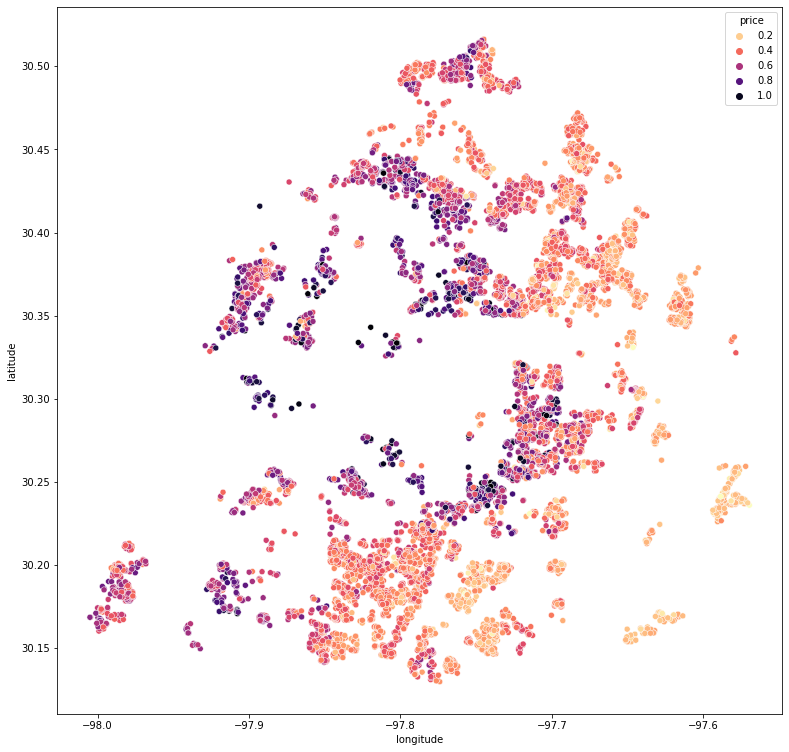

In [60]:
# The improved color map demonstrates the removal of extreme price outliers.

plt.figure(figsize=(13,13))

sns.scatterplot(data=df, x="longitude", y="latitude", hue="price", palette="magma_r");

# **Boolean and Binary Values** 

In [61]:
# Get  columns whose data type is object i.e. bool
filteredColumns = df.dtypes[df.dtypes == np.bool]
# list of columns whose data type is object i.e. string
listOfColumnNames = list(filteredColumns.index)
print(listOfColumnNames)

['hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa', 'hasView']


In [62]:
# convert original boolean columns to binary 0/1
boolean = ['hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa', 'hasView']

for item in boolean:
    df[boolean] = df[boolean].astype(int)
    
df.shape

(8453, 89)

In [63]:
# Select columns that contains the string 'num'
num_cols = [col for col in df.columns if 'num' in col]

print(num_cols)

['numPriceChanges', 'numOfPhotos', 'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures', 'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures', 'numOfWaterfrontFeatures', 'numOfWindowFeatures', 'numOfCommunityFeatures', 'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools', 'numOfHighSchools', 'numOfBathrooms', 'numOfBedrooms', 'numOfStories', 'numPriceChanges_zscore', 'numOfPhotos_zscore', 'numOfAccessibilityFeatures_zscore', 'numOfAppliances_zscore', 'numOfParkingFeatures_zscore', 'numOfPatioAndPorchFeatures_zscore', 'numOfSecurityFeatures_zscore', 'numOfWaterfrontFeatures_zscore', 'numOfWindowFeatures_zscore', 'numOfCommunityFeatures_zscore', 'numOfPrimarySchools_zscore', 'numOfElementarySchools_zscore', 'numOfMiddleSchools_zscore', 'numOfHighSchools_zscore', 'numOfBathrooms_zscore', 'numOfBedrooms_zscore', 'numOfStories_zscore']


In [64]:
# We will also convert some of those num features values to binary values

#This just makes sense to me from a modelling standpoint.  They either have data or they dont

# change all non-null values > 0 in those columns to 1
df.loc[df['numOfAccessibilityFeatures'] > 0, 'numOfAccessibilityFeatures'] = 1
df.loc[df['numOfPatioAndPorchFeatures'] > 0, 'numOfPatioAndPorchFeatures'] = 1
df.loc[df['numOfSecurityFeatures'] > 0, 'numOfSecurityFeatures'] = 1
df.loc[df['numOfWaterfrontFeatures'] > 0, 'numOfWaterfrontFeatures'] = 1
df.loc[df['numOfWindowFeatures'] > 0, 'numOfWindowFeatures'] = 1
df.loc[df['numOfCommunityFeatures'] > 0, 'numOfCommunityFeatures'] = 1

# now anything that is not a 1 becomes a 0
df.loc[df['numOfAccessibilityFeatures']!= 1, 'numOfAccessibilityFeatures'] = 0
df.loc[df['numOfPatioAndPorchFeatures'] != 1, 'numOfPatioAndPorchFeatures'] = 0
df.loc[df['numOfSecurityFeatures'] != 1, 'numOfSecurityFeatures'] = 0
df.loc[df['numOfWaterfrontFeatures'] != 1, 'numOfWaterfrontFeatures'] = 0
df.loc[df['numOfWindowFeatures'] != 1, 'numOfWindowFeatures'] = 0
df.loc[df['numOfCommunityFeatures'] != 1, 'numOfCommunityFeatures'] = 0

In [65]:
#sanity check steps above
df['numOfWindowFeatures'] .describe()

count    8453.000000
mean        0.140305
std         0.347324
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: numOfWindowFeatures, dtype: float64

# Feature Engineering

https://medium.com/@whitcrrd/linear-regression-part-ii-eda-feature-engineering-e66ea8763538

Instead of trying to map out zip codes, we are going to:
Add a column of Price/SqFt to our data.

Group houses by zip code, and find the mean price per square feet for our zip codes

Split zip codes into three types of “neighborhoods” or “groups”: (1) Zip codes that have sold below the average price (cheaper areas); (2) Zip codes that sell above the average price, but not often (don’t want to have their values overrepresented); (3) Zip codes that sell above the average price, and more frequently.
Categorize these groupings as “cheap”, “expensive low volume”, and “expensive high volume”
With this, we can drop zip codes from our dataset, and ignore longitude and latitude, as that should also be encapsulated in the zip code pricing groupings

<AxesSubplot:>

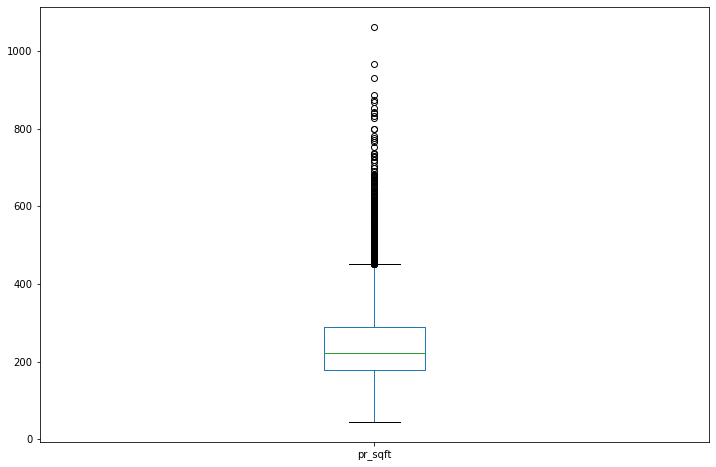

In [66]:
# Calculate Price per square foot
df['pr_sqft'] = df.apply(lambda x: round( (x['price'] / x['livingAreaSqFt'] ), 0), axis=1 )
#evaluate
df['pr_sqft'].plot.box(figsize = (12, 8)) 



In [67]:
frequency = df.groupby('zipcode').count()['zpid'] # group zipcodes, and sum up number of sales
mean = df.groupby('zipcode').mean()['pr_sqft'] # get mean price/sqft for sales
cluster = pd.concat([frequency, mean], axis=1) # combine these
cluster['zipcode'] = cluster.index
cluster.columns = ['frequency', 'pr_sqft', 'zipcode']
cluster.describe()

,frequency,pr_sqft,zipcode
count,39.000000,39.000000,39.000000
mean,216.743590,261.619045,78729.743590
std,166.324622,92.211919,26.996801
min,4.000000,146.721519,78617.000000
25%,92.000000,193.778884,78723.500000
50%,192.000000,231.921875,78733.000000
75%,323.000000,317.421952,78747.500000
max,727.000000,474.500000,78759.000000


The Mean is approximately $262 /sqft so we will use this as a basline and split expensive zones by mean frequency (220), categorize ones below that as low volume, above that as high volume

In [68]:
#Outlier checks

#first Drop some extremes
df=df.loc[df['pr_sqft']< 1000]

In [69]:
# creating "cheap" group that sell below mean price/sqft (264)
cluster_cheap = cluster[cluster.pr_sqft < 262]

# temporary cluster of the houses that sell above mean price/sqft
cluster_temp = cluster[cluster.pr_sqft >= 262]

# creating "low volume, higher priced" group that sell less frequently than the mean
cluster_expensive_low_volume = cluster_temp[cluster_temp.frequency < 217]

# creating "hhigh volume, higher priced" group that sell more frequently than the mean
cluster_expensive_high_volume = cluster_temp[cluster_temp.frequency >= 217]

In [70]:
#function which takes each houses zip code, finds which cluster it belongs to, then adds zipcode type column
def get_zipcode_category(zipcode):
    if zipcode in cluster_cheap.index:
        return 'cheap'
    elif zipcode in cluster_expensive_low_volume.index:
        return 'expensive_low_volume'
    else:
        return 'expensive_high_volume'    

In [71]:
df['zipcode_type'] = df.zipcode.apply(get_zipcode_category)
df.zipcode_type.value_counts() # viewing how our clusters look

cheap                    5555
expensive_high_volume    1681
expensive_low_volume     1216
Name: zipcode_type, dtype: int64

Text(0, 0.5, 'Price')

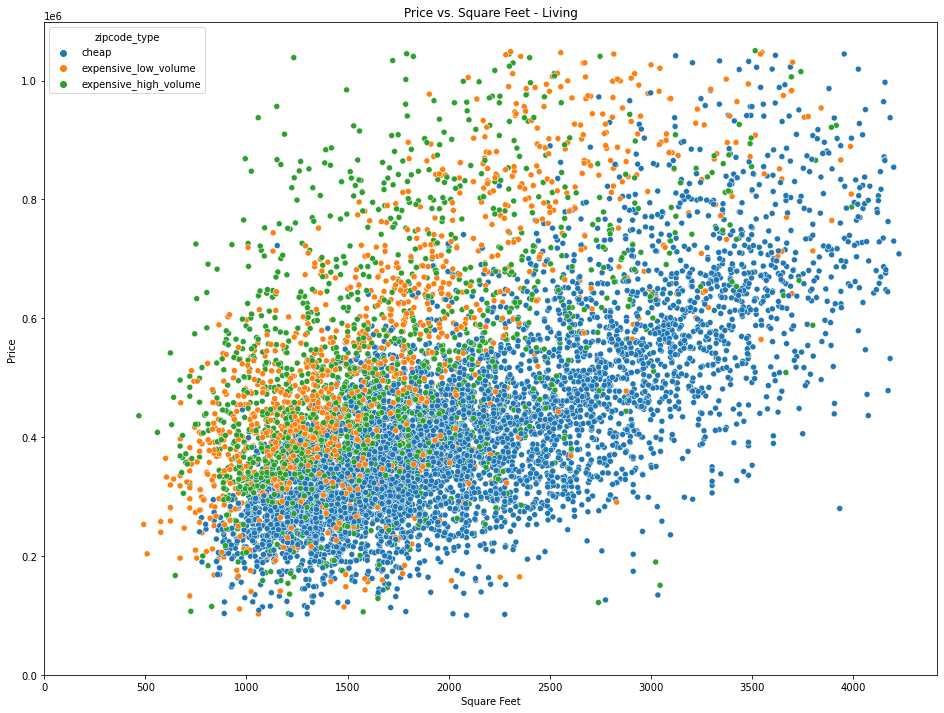

In [72]:
plt.figure(figsize=(16,12))
ax = sns.scatterplot(x="livingAreaSqFt", y="price", data=df, hue="zipcode_type")
plt.xlim(0,None)
plt.ylim(0,None)
plt.title("Price vs. Square Feet - Living")
plt.xlabel("Square Feet")
plt.ylabel("Price")

In [73]:
#Also create a numerical ranking of zipcodes according to same logic

def get_zipcode_rank(zipcode):
    if zipcode in cluster_cheap.index:
        return int(1)
    elif zipcode in cluster_expensive_low_volume.index:
        return int(2)
    else:
        return int(3)   

In [74]:
df['zipcode_rank'] = df.zipcode.apply(get_zipcode_rank)
df.zipcode_rank.value_counts() # viewing how our clusters look

1    5555
3    1681
2    1216
Name: zipcode_rank, dtype: int64

In [75]:
#save a classifications dataframe before dropping categorical features
classify_data_to_use=df

# Continuous Variables - exploration/handling

/Users/adamaldeen/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

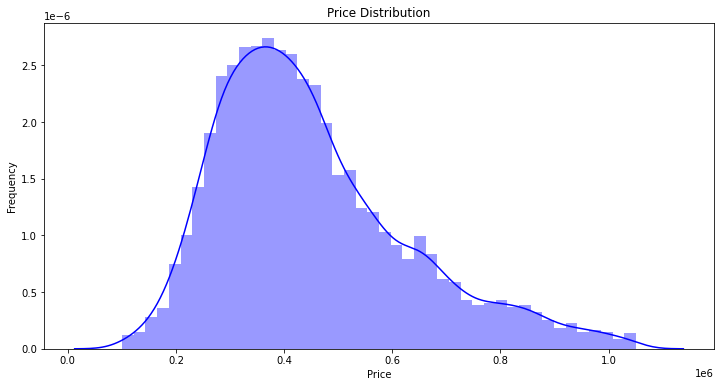

In [76]:
#Visualize price first
fig = plt.figure(figsize=(12,6))
plt.subplot(111)
sns.distplot(df.price, hist=True, kde=True, color='blue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

/Users/adamaldeen/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

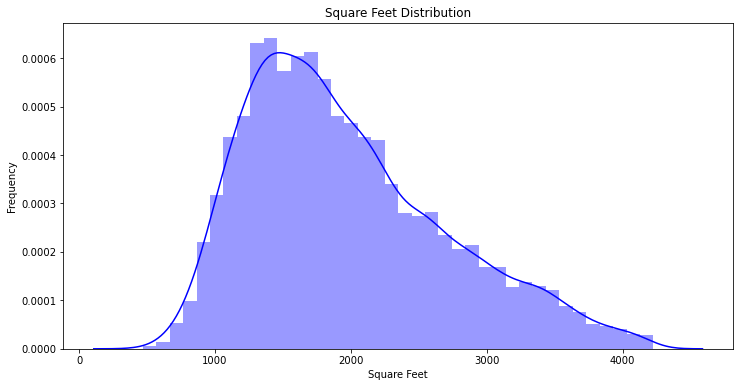

In [77]:
#Visualize Squarefeet
fig = plt.figure(figsize=(12,6))
plt.subplot(111)
sns.distplot(df.livingAreaSqFt, hist=True, kde=True, color='blue')
plt.title('Square Feet Distribution')
plt.xlabel('Square Feet')
plt.ylabel('Frequency')

In [78]:
#Right Skew

In [79]:
df.columns

Index(['price', 'zpid', 'city', 'streetAddress', 'zipcode', 'description',
       'latitude', 'longitude', 'propertyTaxRate', 'garageSpaces',
       'hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa',
       'hasView', 'homeType', 'parkingSpaces', 'yearBuilt', 'orig_price',
       'numPriceChanges', 'latest_saledate', 'latest_salemonth',
       'latest_saleyear', 'latestPriceSource', 'numOfPhotos',
       'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools',
       'numOfHighSchools', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms',
       'numOfBedrooms', 'numOfStories', 'homeImage', 'time_series', 'YearsOld',
       'price_zscore'

**Determine continuous and categorical variables**

In [80]:
#Approach 1
likely_cat = {}
for var in df.columns:
    likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

In [81]:
#Approach 2
top_n = 10 
likely_cat2 = {}
for var in df.columns:
    likely_cat2[var] = 1.*df[var].value_counts(normalize=True).head(top_n).sum() > 0.8 #or some other threshold

In [82]:
likely_cat

{'price': False,
 'zpid': False,
 'city': True,
 'streetAddress': False,
 'zipcode': True,
 'description': False,
 'latitude': False,
 'longitude': False,
 'propertyTaxRate': True,
 'garageSpaces': True,
 'hasAssociation': True,
 'hasCooling': True,
 'hasGarage': True,
 'hasHeating': True,
 'hasSpa': True,
 'hasView': True,
 'homeType': True,
 'parkingSpaces': True,
 'yearBuilt': True,
 'orig_price': False,
 'numPriceChanges': True,
 'latest_saledate': False,
 'latest_salemonth': True,
 'latest_saleyear': True,
 'latestPriceSource': True,
 'numOfPhotos': True,
 'numOfAccessibilityFeatures': True,
 'numOfAppliances': True,
 'numOfParkingFeatures': True,
 'numOfPatioAndPorchFeatures': True,
 'numOfSecurityFeatures': True,
 'numOfWaterfrontFeatures': True,
 'numOfWindowFeatures': True,
 'numOfCommunityFeatures': True,
 'lotSizeSqFt': False,
 'livingAreaSqFt': False,
 'numOfPrimarySchools': True,
 'numOfElementarySchools': True,
 'numOfMiddleSchools': True,
 'numOfHighSchools': True,
 'avg

In [83]:
#Define function to help filter continuous variables from large num of features

def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    return  listOfKeys


**Find keys by value**

-just to help narrow my features

In [84]:
#Define function to help filter continuous variables from large num of features
listOfKeys = getKeysByValue(likely_cat2, False)
print("Continuous Variables")
#Iterate over the list of keys
for key  in listOfKeys:
        print(key)

Continuous Variables
price
zpid
streetAddress
zipcode
description
latitude
longitude
yearBuilt
orig_price
latest_saledate
numOfPhotos
lotSizeSqFt
livingAreaSqFt
avgSchoolDistance
avgSchoolRating
avgSchoolSize
homeImage
YearsOld
price_zscore
zpid_zscore
zipcode_zscore
latitude_zscore
longitude_zscore
yearBuilt_zscore
orig_price_zscore
numOfPhotos_zscore
lotSizeSqFt_zscore
livingAreaSqFt_zscore
avgSchoolDistance_zscore
avgSchoolRating_zscore
avgSchoolSize_zscore
YearsOld_zscore
lat_long
austin_distance
pr_sqft


Right Skew

In [85]:

"""
def log_transform(cat):
    log_cat = (cat - np.mean(cat)) / np.sqrt(np.var(cat))
    return log_cat
  
# normalizing variables by taking log
log_price = np.log(norm_df['price'])
log_sq_living = np.log(norm_df["livingAreaSqFt"])
log_ppsq = np.log(norm_df['pr_sqft'])
log_sq_lot = np.log(norm_df["lotSizeSqFt"])
log_austin_dist = np.log(norm_df['austin_distance'])
# transforming variables so that they are on the same scale

norm_df["livingAreaSqFt"] = log_transform(log_sq_living)
norm_df["livingAreaSqFt"] = log_transform(log_ppsq)
norm_df['price']=log_transform(log_price)
norm_df["lotSizeSqFt"]=log_transform(log_sq_lot)
norm_df["austin_distance"]=log_transform(log_austin_dist)
"""

'\ndef log_transform(cat):\n    log_cat = (cat - np.mean(cat)) / np.sqrt(np.var(cat))\n    return log_cat\n  \n# normalizing variables by taking log\nlog_price = np.log(norm_df[\'price\'])\nlog_sq_living = np.log(norm_df["livingAreaSqFt"])\nlog_ppsq = np.log(norm_df[\'pr_sqft\'])\nlog_sq_lot = np.log(norm_df["lotSizeSqFt"])\nlog_austin_dist = np.log(norm_df[\'austin_distance\'])\n# transforming variables so that they are on the same scale\n\nnorm_df["livingAreaSqFt"] = log_transform(log_sq_living)\nnorm_df["livingAreaSqFt"] = log_transform(log_ppsq)\nnorm_df[\'price\']=log_transform(log_price)\nnorm_df["lotSizeSqFt"]=log_transform(log_sq_lot)\nnorm_df["austin_distance"]=log_transform(log_austin_dist)\n'

I tried normalizing my continuous variables in this step above, but it negatively impacted my regression results, so I commented it out

# Target Variable 

/Users/adamaldeen/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


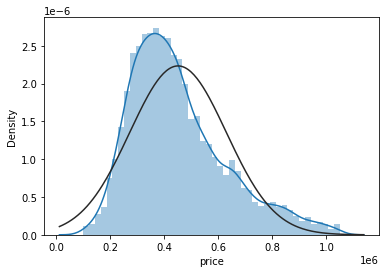

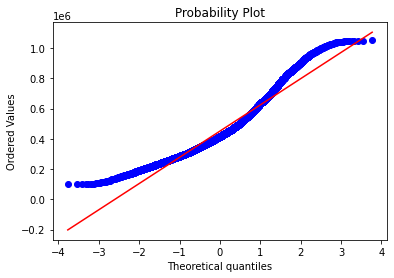

In [86]:
#histogram and normal probability plot
sns.distplot(df['price'], fit=norm);
fig = plt.figure()

res = stats.probplot(df['price'], plot=plt)

# the price histogram is moderately positive skew
# Our QQ-plot confirms the positive skew

In [87]:
#skewness and kurtosis
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

# price is moderately right skewed
# moderate kurtosis

Skewness: 0.912375
Kurtosis: 0.543656


In [88]:
#Prepare to start dropping columns
print(df.columns)

Index(['price', 'zpid', 'city', 'streetAddress', 'zipcode', 'description',
       'latitude', 'longitude', 'propertyTaxRate', 'garageSpaces',
       'hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa',
       'hasView', 'homeType', 'parkingSpaces', 'yearBuilt', 'orig_price',
       'numPriceChanges', 'latest_saledate', 'latest_salemonth',
       'latest_saleyear', 'latestPriceSource', 'numOfPhotos',
       'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools',
       'numOfHighSchools', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms',
       'numOfBedrooms', 'numOfStories', 'homeImage', 'time_series', 'YearsOld',
       'price_zscore'

In [89]:
#Remove zscore columns
# Select columns that contains the string 'score'
score_cols = [col for col in df.columns if 'score' in col]

print(score_cols)

['price_zscore', 'zpid_zscore', 'zipcode_zscore', 'latitude_zscore', 'longitude_zscore', 'propertyTaxRate_zscore', 'garageSpaces_zscore', 'parkingSpaces_zscore', 'yearBuilt_zscore', 'orig_price_zscore', 'numPriceChanges_zscore', 'latest_salemonth_zscore', 'latest_saleyear_zscore', 'numOfPhotos_zscore', 'numOfAccessibilityFeatures_zscore', 'numOfAppliances_zscore', 'numOfParkingFeatures_zscore', 'numOfPatioAndPorchFeatures_zscore', 'numOfSecurityFeatures_zscore', 'numOfWaterfrontFeatures_zscore', 'numOfWindowFeatures_zscore', 'numOfCommunityFeatures_zscore', 'lotSizeSqFt_zscore', 'livingAreaSqFt_zscore', 'numOfPrimarySchools_zscore', 'numOfElementarySchools_zscore', 'numOfMiddleSchools_zscore', 'numOfHighSchools_zscore', 'avgSchoolDistance_zscore', 'avgSchoolRating_zscore', 'avgSchoolSize_zscore', 'MedianStudentsPerTeacher_zscore', 'numOfBathrooms_zscore', 'numOfBedrooms_zscore', 'numOfStories_zscore', 'time_series_zscore', 'YearsOld_zscore']


In [90]:

lst=['price_zscore', 'zpid_zscore', 'zipcode_zscore', 'latitude_zscore', 'longitude_zscore', 'propertyTaxRate_zscore', 'garageSpaces_zscore', 'parkingSpaces_zscore', 'yearBuilt_zscore', 'orig_price_zscore', 'numPriceChanges_zscore', 'latest_salemonth_zscore', 'latest_saleyear_zscore', 'numOfPhotos_zscore', 'numOfAccessibilityFeatures_zscore', 'numOfAppliances_zscore', 'numOfParkingFeatures_zscore', 'numOfPatioAndPorchFeatures_zscore', 'numOfSecurityFeatures_zscore', 'numOfWaterfrontFeatures_zscore', 'numOfWindowFeatures_zscore', 'numOfCommunityFeatures_zscore', 'lotSizeSqFt_zscore', 'livingAreaSqFt_zscore', 'numOfPrimarySchools_zscore', 'numOfElementarySchools_zscore', 'numOfMiddleSchools_zscore', 'numOfHighSchools_zscore', 'avgSchoolDistance_zscore', 'avgSchoolRating_zscore', 'avgSchoolSize_zscore', 'MedianStudentsPerTeacher_zscore', 'numOfBathrooms_zscore', 'numOfBedrooms_zscore', 'numOfStories_zscore', 'time_series_zscore', 'YearsOld_zscore']
df=df.drop(lst,axis=1)


In [91]:
df.columns




Index(['price', 'zpid', 'city', 'streetAddress', 'zipcode', 'description',
       'latitude', 'longitude', 'propertyTaxRate', 'garageSpaces',
       'hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa',
       'hasView', 'homeType', 'parkingSpaces', 'yearBuilt', 'orig_price',
       'numPriceChanges', 'latest_saledate', 'latest_salemonth',
       'latest_saleyear', 'latestPriceSource', 'numOfPhotos',
       'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools',
       'numOfHighSchools', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms',
       'numOfBedrooms', 'numOfStories', 'homeImage', 'time_series', 'YearsOld',
       'lat_long', 'a

In [92]:
#refine regression data
regression_data = df.select_dtypes(exclude= 'object')
#sanity check

regression_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8452 entries, 1 to 11323
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   price                       8452 non-null   float64
 1   zpid                        8452 non-null   int64  
 2   zipcode                     8452 non-null   int64  
 3   latitude                    8452 non-null   float64
 4   longitude                   8452 non-null   float64
 5   propertyTaxRate             8452 non-null   float64
 6   garageSpaces                8452 non-null   int64  
 7   hasAssociation              8452 non-null   int64  
 8   hasCooling                  8452 non-null   int64  
 9   hasGarage                   8452 non-null   int64  
 10  hasHeating                  8452 non-null   int64  
 11  hasSpa                      8452 non-null   int64  
 12  hasView                     8452 non-null   int64  
 13  parkingSpaces               8452

In [93]:
regression_data.columns

Index(['price', 'zpid', 'zipcode', 'latitude', 'longitude', 'propertyTaxRate',
       'garageSpaces', 'hasAssociation', 'hasCooling', 'hasGarage',
       'hasHeating', 'hasSpa', 'hasView', 'parkingSpaces', 'yearBuilt',
       'orig_price', 'numPriceChanges', 'latest_salemonth', 'latest_saleyear',
       'numOfPhotos', 'numOfAccessibilityFeatures', 'numOfAppliances',
       'numOfParkingFeatures', 'numOfPatioAndPorchFeatures',
       'numOfSecurityFeatures', 'numOfWaterfrontFeatures',
       'numOfWindowFeatures', 'numOfCommunityFeatures', 'lotSizeSqFt',
       'livingAreaSqFt', 'numOfPrimarySchools', 'numOfElementarySchools',
       'numOfMiddleSchools', 'numOfHighSchools', 'avgSchoolDistance',
       'avgSchoolRating', 'avgSchoolSize', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'numOfStories', 'time_series',
       'YearsOld', 'austin_distance', 'pr_sqft', 'zipcode_rank'],
      dtype='object')

In [94]:
#Drop most location and time measures since we calculated a category, also calculated measures like pr/sqft

regression_data=regression_data[['price','propertyTaxRate',
       'garageSpaces', 'hasAssociation', 'hasCooling', 'hasGarage',
       'hasHeating', 'hasSpa', 'hasView', 'parkingSpaces', 
        'numPriceChanges', 
       'numOfPhotos', 'numOfAccessibilityFeatures', 'numOfAppliances',
       'numOfParkingFeatures', 'numOfPatioAndPorchFeatures',
       'numOfSecurityFeatures', 'numOfWaterfrontFeatures',
       'numOfWindowFeatures', 'numOfCommunityFeatures', 'lotSizeSqFt',
       'livingAreaSqFt', 'numOfPrimarySchools', 'numOfElementarySchools',
       'numOfMiddleSchools', 'numOfHighSchools', 'avgSchoolDistance',
       'avgSchoolRating', 'avgSchoolSize', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'numOfStories',
       'YearsOld', 'austin_distance','zipcode_rank']]




# Correlations

In [95]:
regression_data.columns

Index(['price', 'propertyTaxRate', 'garageSpaces', 'hasAssociation',
       'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa', 'hasView',
       'parkingSpaces', 'numPriceChanges', 'numOfPhotos',
       'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools',
       'numOfHighSchools', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms',
       'numOfBedrooms', 'numOfStories', 'YearsOld', 'austin_distance',
       'zipcode_rank'],
      dtype='object')

In [96]:
# Check out our variables correlationg with price
correlations=regression_data.corr().unstack().sort_values(ascending=False) #Build correlation Matrix
correlations=pd.DataFrame(correlations).reset_index() #convert to df
correlations.columns=['col1','col2','Correlation']
price_corr=correlations.query("col1 =='price' & col2 !='price' ")
price_corr['Abs Corr']=abs(price_corr['Correlation'])
pd.set_option("display.max_rows", None, "display.max_columns", None)
price_corr.sort_values(by='Abs Corr',ascending=False)

/Users/adamaldeen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,col1,col2,Correlation,Abs Corr
66,price,livingAreaSqFt,0.553708,0.553708
70,price,avgSchoolRating,0.489417,0.489417
79,price,numOfBathrooms,0.415019,0.415019
87,price,lotSizeSqFt,0.394720,0.394720
99,price,MedianStudentsPerTeacher,0.359643,0.359643
114,price,numOfBedrooms,0.319392,0.319392
1058,price,numOfHighSchools,-0.258932,0.258932
147,price,zipcode_rank,0.238032,0.238032
159,price,numOfStories,0.220112,0.220112
1042,price,numOfPrimarySchools,-0.189335,0.189335


# Collinearity

We can calculate the Variance Inflation Factor to help detect multicollinearity

-The higher the VIF,

-The more correlated a predictor is with the other predictors

-The more the standard error is inflated

-The larger the confidence interval

-The less likely it is that a coefficient will be evaluated as statistically significant

-An acceptable VIF is if it’s less than the max of 10 and 1/1-R²model (see below):

*Note, some features , especially categorical ones like Zipcode do not have a meaninful interpretation from VIF

In [97]:
#import method of detecting collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

#isolate price colume
mod_df = regression_data[~regression_data.isin([np.nan, np.inf, -np.inf]).any(1)]
x_features=mod_df.drop('price',axis=1)

vif_data = pd.DataFrame()
vif_data["feature"] = x_features.columns
vif_data["VIF"] = [variance_inflation_factor(x_features.values, i) for i in range(len(x_features.columns))]
vif_data.sort_values(by="VIF",ascending=True)

/Users/adamaldeen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/adamaldeen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,feature,VIF
6,hasSpa,1.143855
7,hasView,1.357205
17,numOfWindowFeatures,1.468147
15,numOfSecurityFeatures,2.179934
14,numOfPatioAndPorchFeatures,2.572137
9,numPriceChanges,2.687485
10,numOfPhotos,3.752743
22,numOfElementarySchools,4.447787
12,numOfAppliances,4.985952
2,hasAssociation,5.232527


# Feature Selection

-Also use Correlations and calculations above to help select features

In [98]:
#Drop the inf and nan VIF features

vif_data= vif_data[~vif_data.isin([np.nan, np.inf, -np.inf]).any(1)]
vif_data['feature'].values

array(['propertyTaxRate', 'hasAssociation', 'hasCooling', 'hasGarage',
       'hasHeating', 'hasSpa', 'hasView', 'numPriceChanges',
       'numOfPhotos', 'numOfAppliances', 'numOfParkingFeatures',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWindowFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'numOfPrimarySchools', 'numOfElementarySchools',
       'numOfMiddleSchools', 'numOfHighSchools', 'avgSchoolDistance',
       'avgSchoolRating', 'avgSchoolSize', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'numOfStories', 'YearsOld',
       'austin_distance', 'zipcode_rank'], dtype=object)

In [99]:
clean_feats=vif_data.loc[vif_data['VIF']<=10]
clean_feats['feature'].values

array(['hasAssociation', 'hasSpa', 'hasView', 'numPriceChanges',
       'numOfPhotos', 'numOfAppliances', 'numOfPatioAndPorchFeatures',
       'numOfSecurityFeatures', 'numOfWindowFeatures',
       'numOfElementarySchools', 'avgSchoolDistance', 'YearsOld',
       'austin_distance', 'zipcode_rank'], dtype=object)

In [100]:
#Use the Above data to help select features to use, also removing calculated features from above / features that are similar
#exclude values above 10

x_features=regression_data[['hasAssociation', 'hasSpa', 'hasView', 'numPriceChanges',
       'numOfPhotos', 'numOfAppliances', 'numOfPatioAndPorchFeatures',
       'numOfSecurityFeatures', 'numOfWindowFeatures', 'livingAreaSqFt',
       'numOfElementarySchools', 'avgSchoolDistance', 'YearsOld',
       'austin_distance', 'zipcode_rank']]


In [101]:
#Determine columns again
regression_data.columns

Index(['price', 'propertyTaxRate', 'garageSpaces', 'hasAssociation',
       'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa', 'hasView',
       'parkingSpaces', 'numPriceChanges', 'numOfPhotos',
       'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools',
       'numOfHighSchools', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms',
       'numOfBedrooms', 'numOfStories', 'YearsOld', 'austin_distance',
       'zipcode_rank'],
      dtype='object')

In [102]:
#Create trainging and test data
X=x_features
y=regression_data['price'].values

#split the data in to training and test datasets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20)



The scikit-learn machine library provides an implementation of the correlation statistic in the f_regression() function. This function can be used in a feature selection strategy, such as selecting the top k most relevant features (largest values) via the SelectKBest class.

-Higher is better

function via : https://machinelearningmastery.com/feature-selection-for-regression-data/


Feature 0: 7.715844
Feature 1: 86.576580
Feature 2: 80.839656
Feature 3: 12.405292
Feature 4: 102.959943
Feature 5: 0.878289
Feature 6: 9.499365
Feature 7: 5.236961
Feature 8: 22.709921
Feature 9: 3035.837828
Feature 10: 159.998869
Feature 11: 1.011437
Feature 12: 0.018064
Feature 13: 88.366902
Feature 14: 411.429645


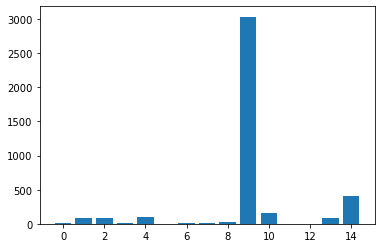

In [103]:
# example of correlation feature selection for numerical data



#feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)


# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()


# Regression

In [104]:
#Build the model, using top features

# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k=10)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs



In [105]:

X=x_features
y=regression_data['price'].values

#split the data in to training and test datasets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20)



# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

#X_train= StandardScaler().fit_transform(X_train)
# fit the model
model = LinearRegression()
model=model.fit(X_train_fs, y_train)
clf=model.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
mse=np.sqrt(mt.mean_squared_error(y_test,yhat))

print('Mean Absolute Error: %.3f' % mae)

print('Mean Squared Error: %.3f' %  mse)




Mean Absolute Error: 95122.278
Mean Squared Error: 126115.778


In [106]:
#Print intercepts and coeffcient

print("Coefficient : ",clf.coef_)
print("Y Intercept : ",clf.intercept_)

Coefficient :  [-55681.77844227  21872.92643572  13447.7667357  -10408.30294002
    155.6772279   13780.86499383    174.83970152  50099.35327093
   3279.01886444  86440.88480208]
Y Intercept :  -3288.8505353413057


In [107]:
#Print some predictions

predictions = model.predict(X_test_fs)
for index in range(1,10):
    print('Actual : ' , y_test[index], 'Predicted: ',predictions[index])

Actual :  317444.0 Predicted:  449177.6552767369
Actual :  268972.0 Predicted:  363239.8420993494
Actual :  931361.0 Predicted:  648236.8763656528
Actual :  641410.0 Predicted:  761937.5614289459
Actual :  256910.0 Predicted:  276531.0693113357
Actual :  288673.0 Predicted:  426764.8861127021
Actual :  357902.0 Predicted:  508176.2456051276
Actual :  375045.0 Predicted:  413224.33048490714
Actual :  676144.0 Predicted:  642348.0317899605


In [108]:
#OLS Results
x=(X_train_fs)
XX=sm.add_constant(x)
model = sm.OLS(y_train, XX).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     726.4
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        10:48:39   Log-Likelihood:                -88856.
No. Observations:                6761   AIC:                         1.777e+05
Df Residuals:                    6750   BIC:                         1.778e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3288.8505   7140.959     -0.461      0.6

Feature 0: 8.689386
Feature 1: 76.506383
Feature 2: 78.083277
Feature 3: 6.683145
Feature 4: 86.388743
Feature 5: 1.597830
Feature 6: 4.838983
Feature 7: 0.820030
Feature 8: 24.401685
Feature 9: 2961.995247
Feature 10: 127.103760
Feature 11: 1.901733
Feature 12: 1.637978
Feature 13: 88.553716
Feature 14: 416.062379


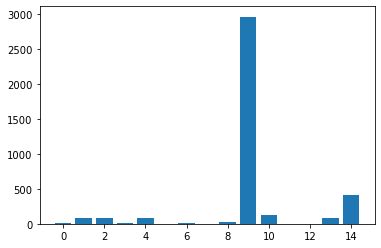

In [109]:
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [110]:
#Shapes
print(X_train_fs.shape)
print(X_test_fs.shape)
print(y_test.shape)
print(yhat.shape)
#print(x_test.shape)

(6761, 10)
(1691, 10)
(1691,)
(1691,)


**Print Selected Feature Names**

In [111]:
cols=fs.get_support(indices=True)
features_df=x_features.iloc[:,cols]
features_df.columns

Index(['hasAssociation', 'hasSpa', 'hasView', 'numPriceChanges', 'numOfPhotos',
       'numOfWindowFeatures', 'livingAreaSqFt', 'numOfElementarySchools',
       'austin_distance', 'zipcode_rank'],
      dtype='object')

In [112]:
#Evaluate

#add constant to test set
X_test_fs=sm.add_constant(X_test_fs)
predictions = model.predict(X_test_fs)


/Users/adamaldeen/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Errors')

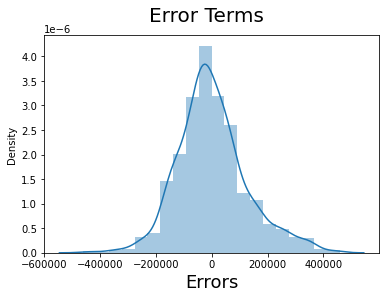

In [113]:
res = (predictions - y_test)
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_test - predictions), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)  

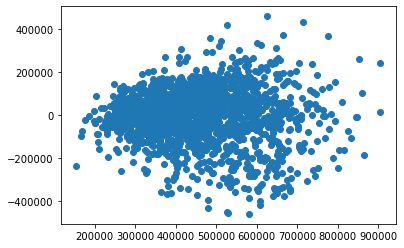

In [114]:
plt.scatter(predictions,res)
plt.show()

# Random Forest Regression

In [115]:
X=x_features
y=regression_data['price'].values

#split the data in to training and test datasets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20)





rand_forest=RandomForestRegressor(max_depth=13,random_state=0)
rand_forest.fit(X_train, y_train)
y_pred=rand_forest.predict(X_test)

print("R squared : ")
print(mt.r2_score(y_test,y_pred))

R squared : 
0.6847191687874955


In [116]:
#Print some predictions


for index in range(1,10):
    print('Actual : ' , y_test[index], 'Predicted: ',y_pred[index])

Actual :  322090.0 Predicted:  297311.51417603524
Actual :  499857.0 Predicted:  488003.8451237264
Actual :  579554.0 Predicted:  570062.56714764
Actual :  327383.0 Predicted:  410434.49590517825
Actual :  323398.0 Predicted:  313843.4027679391
Actual :  499217.0 Predicted:  402404.4496889211
Actual :  662723.0 Predicted:  541305.6006345277
Actual :  635800.0 Predicted:  531513.0792865147
Actual :  688346.0 Predicted:  621521.0796021608


In [117]:
# evaluate predictions
mae = mean_absolute_error(y_test, y_pred)
mse=np.sqrt(mt.mean_squared_error(y_test,y_pred))

print('Mean Absolute Error: %.3f' % mae)

print('Root Mean Squared Error: %.3f' %  mse)

Mean Absolute Error: 73013.042
Root Mean Squared Error: 98664.245


In [118]:
print(X_test.shape)
print(y_test.shape)
print(y_pred.shape)

(1691, 15)
(1691,)
(1691,)


In [119]:
residual = (y_pred - y_test)
print(residual.shape)

(1691,)


/Users/adamaldeen/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Errors')

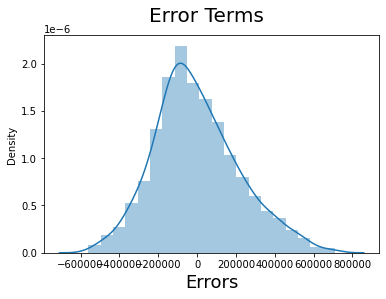

In [120]:
fig = plt.figure()
sns.distplot((y_test - predictions), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)  

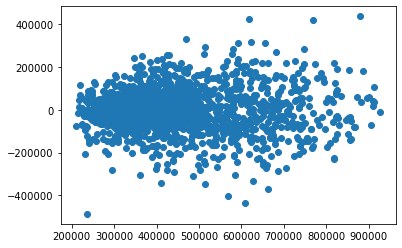

In [121]:
plt.scatter(y_pred,residual)
plt.show()

# Classification

-Classification of data against Hometype

In [122]:
classify_data_to_use.columns

Index(['price', 'zpid', 'city', 'streetAddress', 'zipcode', 'description',
       'latitude', 'longitude', 'propertyTaxRate', 'garageSpaces',
       'hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa',
       'hasView', 'homeType', 'parkingSpaces', 'yearBuilt', 'orig_price',
       'numPriceChanges', 'latest_saledate', 'latest_salemonth',
       'latest_saleyear', 'latestPriceSource', 'numOfPhotos',
       'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools',
       'numOfHighSchools', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms',
       'numOfBedrooms', 'numOfStories', 'homeImage', 'time_series', 'YearsOld',
       'price_zscore'

In [123]:
#Remove zscore columns
# Select columns that contains the string 'score'
score_cols = [col for col in classify_data_to_use.columns if 'score' in col]

print(score_cols)

['price_zscore', 'zpid_zscore', 'zipcode_zscore', 'latitude_zscore', 'longitude_zscore', 'propertyTaxRate_zscore', 'garageSpaces_zscore', 'parkingSpaces_zscore', 'yearBuilt_zscore', 'orig_price_zscore', 'numPriceChanges_zscore', 'latest_salemonth_zscore', 'latest_saleyear_zscore', 'numOfPhotos_zscore', 'numOfAccessibilityFeatures_zscore', 'numOfAppliances_zscore', 'numOfParkingFeatures_zscore', 'numOfPatioAndPorchFeatures_zscore', 'numOfSecurityFeatures_zscore', 'numOfWaterfrontFeatures_zscore', 'numOfWindowFeatures_zscore', 'numOfCommunityFeatures_zscore', 'lotSizeSqFt_zscore', 'livingAreaSqFt_zscore', 'numOfPrimarySchools_zscore', 'numOfElementarySchools_zscore', 'numOfMiddleSchools_zscore', 'numOfHighSchools_zscore', 'avgSchoolDistance_zscore', 'avgSchoolRating_zscore', 'avgSchoolSize_zscore', 'MedianStudentsPerTeacher_zscore', 'numOfBathrooms_zscore', 'numOfBedrooms_zscore', 'numOfStories_zscore', 'time_series_zscore', 'YearsOld_zscore']


In [124]:
lst=['price_zscore', 'zpid_zscore', 'zipcode_zscore', 'latitude_zscore', 'longitude_zscore', 'propertyTaxRate_zscore', 'garageSpaces_zscore', 'parkingSpaces_zscore', 'yearBuilt_zscore', 'orig_price_zscore', 'numPriceChanges_zscore', 'latest_salemonth_zscore', 'latest_saleyear_zscore', 'numOfPhotos_zscore', 'numOfAccessibilityFeatures_zscore', 'numOfAppliances_zscore', 'numOfParkingFeatures_zscore', 'numOfPatioAndPorchFeatures_zscore', 'numOfSecurityFeatures_zscore', 'numOfWaterfrontFeatures_zscore', 'numOfWindowFeatures_zscore', 'numOfCommunityFeatures_zscore', 'lotSizeSqFt_zscore', 'livingAreaSqFt_zscore', 'numOfPrimarySchools_zscore', 'numOfElementarySchools_zscore', 'numOfMiddleSchools_zscore', 'numOfHighSchools_zscore', 'avgSchoolDistance_zscore', 'avgSchoolRating_zscore', 'avgSchoolSize_zscore', 'MedianStudentsPerTeacher_zscore', 'numOfBathrooms_zscore', 'numOfBedrooms_zscore', 'numOfStories_zscore', 'time_series_zscore', 'YearsOld_zscore']
classify_data_to_use=classify_data_to_use.drop(lst,axis=1)


In [125]:
#refine classification data
class_x= classify_data_to_use.select_dtypes(exclude= 'object')
#sanity check

class_x.columns

Index(['price', 'zpid', 'zipcode', 'latitude', 'longitude', 'propertyTaxRate',
       'garageSpaces', 'hasAssociation', 'hasCooling', 'hasGarage',
       'hasHeating', 'hasSpa', 'hasView', 'parkingSpaces', 'yearBuilt',
       'orig_price', 'numPriceChanges', 'latest_salemonth', 'latest_saleyear',
       'numOfPhotos', 'numOfAccessibilityFeatures', 'numOfAppliances',
       'numOfParkingFeatures', 'numOfPatioAndPorchFeatures',
       'numOfSecurityFeatures', 'numOfWaterfrontFeatures',
       'numOfWindowFeatures', 'numOfCommunityFeatures', 'lotSizeSqFt',
       'livingAreaSqFt', 'numOfPrimarySchools', 'numOfElementarySchools',
       'numOfMiddleSchools', 'numOfHighSchools', 'avgSchoolDistance',
       'avgSchoolRating', 'avgSchoolSize', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'numOfStories', 'time_series',
       'YearsOld', 'austin_distance', 'pr_sqft', 'zipcode_rank'],
      dtype='object')

In [126]:
#Drop some redundant features
lst=['price', 'propertyTaxRate',
       'garageSpaces', 'hasAssociation', 'hasCooling', 'hasGarage',
       'hasHeating', 'hasSpa', 'hasView', 'parkingSpaces',
       'numPriceChanges', 
       'numOfPhotos', 'numOfAccessibilityFeatures', 'numOfAppliances',
       'numOfParkingFeatures', 'numOfPatioAndPorchFeatures',
       'numOfSecurityFeatures', 'numOfWaterfrontFeatures',
       'numOfWindowFeatures', 'numOfCommunityFeatures', 'lotSizeSqFt',
       'livingAreaSqFt', 'numOfPrimarySchools', 'numOfElementarySchools',
       'numOfMiddleSchools', 'numOfHighSchools', 'avgSchoolDistance',
       'avgSchoolRating', 'avgSchoolSize', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'numOfStories',
       'YearsOld', 'austin_distance', 'pr_sqft', 'zipcode_rank']
class_x=class_x[['price', 'propertyTaxRate',
       'garageSpaces', 'hasAssociation', 'hasCooling', 'hasGarage',
       'hasHeating', 'hasSpa', 'hasView', 'parkingSpaces',
       'numPriceChanges', 
       'numOfPhotos', 'numOfAccessibilityFeatures', 'numOfAppliances',
       'numOfParkingFeatures', 'numOfPatioAndPorchFeatures',
       'numOfSecurityFeatures', 'numOfWaterfrontFeatures',
       'numOfWindowFeatures', 'numOfCommunityFeatures', 'lotSizeSqFt',
       'livingAreaSqFt', 'numOfPrimarySchools', 'numOfElementarySchools',
       'numOfMiddleSchools', 'numOfHighSchools', 'avgSchoolDistance',
       'avgSchoolRating', 'avgSchoolSize', 'MedianStudentsPerTeacher',
       'numOfBathrooms', 'numOfBedrooms', 'numOfStories',
       'YearsOld', 'austin_distance', 'pr_sqft', 'zipcode_rank']]

class_x.columns

Index(['price', 'propertyTaxRate', 'garageSpaces', 'hasAssociation',
       'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa', 'hasView',
       'parkingSpaces', 'numPriceChanges', 'numOfPhotos',
       'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools',
       'numOfHighSchools', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms',
       'numOfBedrooms', 'numOfStories', 'YearsOld', 'austin_distance',
       'pr_sqft', 'zipcode_rank'],
      dtype='object')

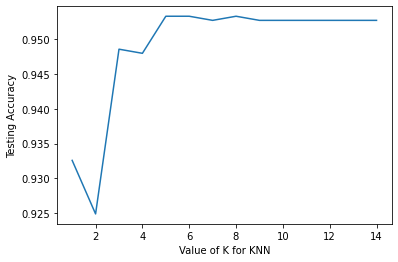

In [127]:

#KNN Classification


#define y1

y1=classify_data_to_use['homeType'].values

#define x

x=class_x


#Split the data into test and training sets
X_train,X_test,y_train,y_test=train_test_split(x,y1,test_size=0.2,random_state=0)

#Test for accuracy to select K

scores=[]
K_range=range(1,15)

for k in K_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred=knn.predict(X_test)
    scores.append(accuracy_score(y_test,y_pred))

plt.plot(K_range,scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.show()

In [128]:
#Baccuracy is similar for most k's. choosing 5 for sake of processing
#use k=5 for classification model


knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
pred=knn.predict(X_test)

#Print confusion matrix
print('\nModel Accuracy Score: ',accuracy_score(y_test,pred))
print('\nConfusion Matrix\n',confusion_matrix(y_test,pred))


Model Accuracy Score:  0.9532820816085157

Confusion Matrix
 [[   2   54    0]
 [   2 1609    0]
 [   0   23    1]]


In [129]:
#Print some predictions


for index in range(1,15):
    print('Actual : ' , y_test[index], 'Predicted: ',pred[index])

Actual :  Townhouse Predicted:  Single Family
Actual :  Single Family Predicted:  Single Family
Actual :  Single Family Predicted:  Single Family
Actual :  Single Family Predicted:  Single Family
Actual :  Single Family Predicted:  Single Family
Actual :  Single Family Predicted:  Single Family
Actual :  Single Family Predicted:  Single Family
Actual :  Condo Predicted:  Single Family
Actual :  Single Family Predicted:  Single Family
Actual :  Single Family Predicted:  Single Family
Actual :  Single Family Predicted:  Single Family
Actual :  Single Family Predicted:  Single Family
Actual :  Single Family Predicted:  Single Family
Actual :  Single Family Predicted:  Single Family


In [130]:
classify_data_to_use['homeType'].unique()

array(['Single Family', 'Townhouse', 'Condo'], dtype=object)

In [131]:
classify_data_to_use.columns

Index(['price', 'zpid', 'city', 'streetAddress', 'zipcode', 'description',
       'latitude', 'longitude', 'propertyTaxRate', 'garageSpaces',
       'hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa',
       'hasView', 'homeType', 'parkingSpaces', 'yearBuilt', 'orig_price',
       'numPriceChanges', 'latest_saledate', 'latest_salemonth',
       'latest_saleyear', 'latestPriceSource', 'numOfPhotos',
       'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools',
       'numOfHighSchools', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms',
       'numOfBedrooms', 'numOfStories', 'homeImage', 'time_series', 'YearsOld',
       'lat_long', 'a

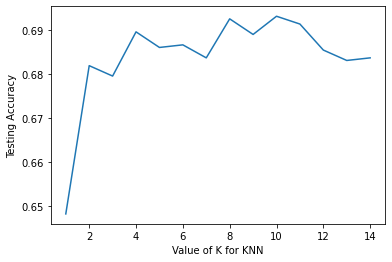

In [132]:
#define y1

y2=classify_data_to_use['zipcode_type'].values

#define x

x=class_x


#Split the data into test and training sets
X_train,X_test,y_train,y_test=train_test_split(x,y2,test_size=0.2,random_state=0)

#Test for accuracy to select K

scores=[]
K_range=range(1,15)

for k in K_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred=knn.predict(X_test)
    scores.append(accuracy_score(y_test,y_pred))

plt.plot(K_range,scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.show()

In [133]:
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
pred=knn.predict(X_test)

#Print confusion matrix
print('\nModel Accuracy Score: ',accuracy_score(y_test,pred))
print('\nConfusion Matrix\n',confusion_matrix(y_test,pred))


Model Accuracy Score:  0.6859846244825547

Confusion Matrix
 [[1041   53   16]
 [ 214   86   25]
 [ 162   61   33]]


In [134]:
#Print some predictions


for index in range(1,10):
    print('Actual : ' , y_test[index], 'Predicted: ',pred[index])

Actual :  expensive_low_volume Predicted:  expensive_high_volume
Actual :  expensive_low_volume Predicted:  expensive_high_volume
Actual :  cheap Predicted:  cheap
Actual :  expensive_low_volume Predicted:  expensive_high_volume
Actual :  cheap Predicted:  cheap
Actual :  cheap Predicted:  expensive_low_volume
Actual :  cheap Predicted:  cheap
Actual :  expensive_low_volume Predicted:  cheap
Actual :  expensive_high_volume Predicted:  cheap
